# Machine Learning Project
## Mbusu-Team

### **House Prices Dataset**

### **Data Understanding**

In [229]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sb
from scipy.stats import entropy
import math
import sys
from itertools import groupby
plt.style.use('ggplot')


hue_order = ["HIGH","MEDIUM","LOW"]
color = ["#BF4E30","#2E86AB","#E7A012"]
palette = {
    'LOW': color[0],
    'MEDIUM': color[1],
    'HIGH': color[2],
}
TARGET_FEATURE = 'SalePrice'
TARGET_FEATURE_CONTI = 'salePriceNum'
TARGET_FEATURE_VALUES = ['LOW', 'MEDIUM', 'HIGH']

#### Utils

###### INFORMATION GAIN FUNTION 

In [230]:
def IG(df, target, attribute):

    df_sub = []

    for value in df[attribute].unique():
        df_sub.append( df[df[attribute] == value] )
        
    counts = df[target].value_counts()
    probs = counts / len(df)
    e = -np.sum(probs * np.log2(probs))

    information_gain = e 
    for df_s in df_sub:
        counts = df_s[target].value_counts()
        probs = counts / len(df_s)
        e_s = -np.sum(probs * np.log2(probs))
        information_gain -= len(df_s) / len(df) * e_s

    return information_gain


###### Mean

In [231]:
def mean_attribute(df, attribute):
    mean_low = df[ ( df["SalePrice"] == 'LOW' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_medium = df[ ( df["SalePrice"] == 'MEDIUM' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_high = df[ ( df["SalePrice"] == 'HIGH' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    return (mean_low, mean_medium, mean_high)



###### Set means

In [232]:
def set_means(df,attribute):
    mean_values = mean_attribute(df,attribute)

    for ind , e  in df.iterrows():
        if e[attribute] == "NA":
            if(e["SalePrice"] == "LOW"):
                df.at[ind, attribute] = mean_values[0]
            elif e["SalePrice"] == "MEDIUM":
                df.at[ind, attribute] = mean_values[1]
            else:
                df.at[ind, attribute] = mean_values[2]


    df[attribute] = df[attribute].astype("int")


###### Plot frequencies and percentages

In [233]:
def frequencies_and_percentages(df, target, attribute):
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    dfp = df[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df[target].unique()), axis='index'))
    display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color )
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )

###### Histplot

In [234]:

def histplot(df,target, attribute, bins = 200 , figsize=(15,5), xticks_rot=0, xlim = None):
    plt.figure(figsize = figsize)
    sb.histplot(x = df[attribute], hue = target, data = df, kde=True , hue_order = hue_order, palette = palette, bins = bins , common_bins= False)
    plt.xticks(rotation=xticks_rot)
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()

###### indepence_test_categoric

In [235]:

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            if pos % 3 == 0: add_line(ax, pos*scale, ypos - .052)
            pos += rpos
        add_line(ax, pos*scale , ypos - .052)
        ypos -= .05

def barplot_diffvalues(dataset, feature_name):
    df = dataset.reset_index().groupby([feature_name, TARGET_FEATURE]).sum()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    #print(dataset)
    dataset.pivot_table(index = [feature_name, TARGET_FEATURE], columns=['__Type']).plot(kind='bar', ax=ax, width=.7)
    
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title('Expected/Observed Frequencies')
    ax.set_xlabel(f'{feature_name}/{TARGET_FEATURE}', labelpad=40)
    ax.set_ylabel(f'{TARGET_FEATURE}')
    plt.legend(['Expected', 'Observed'])
    label_group_bar_table(ax, df)

    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    plt.show()

def stattest_quali(df, feature_name: str, fig_width=15, fig_height=3, typeplot = 'heatmap', silent: bool=False):

    #
    # chi-square test and expected frequencies matrix
    #
    crosstab = pd.crosstab(df[feature_name], df[TARGET_FEATURE])
    chi_square_args = crosstab.values
    _, p_value, _, _ = stats.chi2_contingency(chi_square_args)

    expf_crosstab = pd.DataFrame(crosstab)
    for idx in expf_crosstab.index:
        for col in expf_crosstab.columns:
            expf_crosstab.at[idx, col] = crosstab.loc[idx].values.sum() * crosstab[col].values.sum() / crosstab.values.sum()

    if not silent:
        #
        # observed/expected frequencies heatmaps
        #
        fig_width = min(fig_width, 1.5 * len(df[feature_name].unique()))
        fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_height * 2))
        sb.heatmap(crosstab.T, ax=ax[0], annot=True, cmap='coolwarm', fmt='.2f')
        sb.heatmap(expf_crosstab.T, ax=ax[1], annot=True, cmap='coolwarm', fmt='.2f')
        ax[0].set_title('Observed Frequencies')    
        ax[1].set_title('Expected Frequencies')
        fig.tight_layout()
        plt.show()

        if(typeplot == 'heatmap'):
            
            #
            # frequencies difference heatmap
            #
            obsexp_diff_df = crosstab - expf_crosstab
            fig = plt.figure(figsize=(fig_width, fig_height))
            plt.title("Frequency Differences (Observed - Expected)")
            sb.heatmap(obsexp_diff_df.T, annot=True, cmap='vlag', fmt='.2f')
        
        elif typeplot == 'barplot':
            #
            # observed/expected frequencies barplot
            #
            value_vars_x = [val + '_x' for val in TARGET_FEATURE_VALUES]
            value_vars_y = [val + '_y' for val in TARGET_FEATURE_VALUES]
            value_vars_xy = value_vars_x + value_vars_y
            obs_exp_df = pd.merge(crosstab, expf_crosstab, on=[feature_name]).reset_index()
            obs_exp_df = pd.melt(obs_exp_df, id_vars=[feature_name], value_vars=value_vars_xy)
            obs_exp_df['__Type'] = obs_exp_df[TARGET_FEATURE]

            for val in value_vars_x: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__OBS'
            for val in value_vars_y: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__EXP'

            for price in TARGET_FEATURE_VALUES:
                for obs_exp in ['x', 'y']:
                    obs_exp_df.loc[obs_exp_df[TARGET_FEATURE] == price + '_' + obs_exp, TARGET_FEATURE] = price[0]

            barplot_diffvalues(obs_exp_df, feature_name)

    #
    # chi-square test outcome
    #
    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    if not silent:
        print("Chi-square Test - Outcome")
        print("P-Value:", p_value, p_value_info)
    return p_value, p_value_info

###### indepence_test_numeric

In [236]:
def stattest_quanti(df, feature_name: str, target = TARGET_FEATURE ,low_limit=0, upper_limit=100, silent = False):

    #
    # plot means w.r.t. target categories
    #
    df_conti_origin = df[[feature_name, target, TARGET_FEATURE_CONTI]] if ( target == TARGET_FEATURE) else None
    df_categ_origin = df[[feature_name, target]]
    df = df_categ_origin.groupby(target)
    mean_df = df.mean().reset_index().rename(columns={feature_name: feature_name + ' (AVG)'})

    num = 3
    if df_conti_origin is None:
        num = 2
    _, ax = plt.subplots(1, num, figsize=(20, 5))

    mean_df.plot(kind='bar', x=target, ax=ax[0])
    for container in ax[0].containers:
        ax[0].bar_label(container, fmt='%.1f')
    ax[0].set_ylim(low_limit, upper_limit)
    ax[0].tick_params(labelrotation=0)

    sb.histplot(x=feature_name, hue=target, data=df_categ_origin, kde=True, ax=ax[1])
    for tval in TARGET_FEATURE_VALUES:
        ax[1].axvline(x=df_categ_origin[df_categ_origin[target] == tval][feature_name].mean(), color='gray', ls='--', lw=1.5)
    
    if df_conti_origin is not None : sb.regplot(x=feature_name, y=TARGET_FEATURE_CONTI, data=df_conti_origin, line_kws={"color": "darkred"}, ax=ax[2])
    
    #
    # perform ANOVA test
    #
    anova_args = tuple(df[feature_name].apply(list).reset_index()[feature_name])
    f_statistic, p_value = stats.f_oneway(*anova_args)

    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    if not silent:
        print("ANOVA Test - Outcome")
        print("P-Value:", p_value, p_value_info)
    return p_value, p_value_info

###### Numeric Numeric Correlation

In [237]:
def correlation(df, n1, n2, silent = False):

    sb.regplot(x=n1, y=n2, data=df, line_kws={"color": "darkred"})
    
    corr, p_values = stats.pearsonr(df[n1], df[n2])
    
    if not silent:
        print(corr, p_values)

    return (corr, p_values)

###### Categoric Ordinal Plots & Stattest

In [238]:
def categoric_ordinal_plot(df, attr, test_typeplot='heatmap'):
    df2 = df.copy(deep=True)

    attr_values = df2[attr].unique().tolist()
    df2[attr] = df2[attr].astype('object')
    for val in attr_values: df2.loc[df2[attr] == val, attr] = attr + '_' + str(val)
    df2[attr] = df2[attr].astype('category')

    frequencies_and_percentages(df2, TARGET_FEATURE, attr)
    stattest_quali(df2, attr, typeplot=test_typeplot)
    print(IG(df, TARGET_FEATURE, attr))

###### Understanding 

In [292]:
def understand(dataf: pd.DataFrame, feature_name: str, dtype: str='category', \
               predconf_max: float=1.0, predconf_min: float=0.33, showplots=True, na = 'NA', bins = 50, \
               low_limit = 0, upper_limit = 100 , xlim = None):
    data_feature = dataf[feature_name]
    data_target = dataf[TARGET_FEATURE]
    report = ''
    report += "Understanding %s:" % feature_name + "\n"
    
    #
    # count missing values
    #
    miss_values = data_feature.isna().sum()
    miss_values += dataf[data_feature == na ].index.size
    report += "\tMissing values: " + str(miss_values) + "\n"

    data_feature = data_feature.astype(dtype)

    if dtype == 'category' or dtype == 'object':

        if dtype == 'object':
            attr_values = data_feature.unique().tolist()
            data_feature = data_feature.astype('object')
            for ind in range(len(dataf)): data_feature[ind] = feature_name + '_' + str(data_feature[ind])
            data_feature = data_feature.astype('category')
            dataf[feature_name] = data_feature

        if showplots: 
            frequencies_and_percentages(dataf, TARGET_FEATURE, feature_name)
        #
        # perform the independence test
        #
        p_value, p_value_info = stattest_quali(dataf, feature_name, typeplot='heatmap' if showplots else'none', silent=not showplots)
        report += "\tIndependence Test: " + '{:.2e}'.format(p_value) + p_value_info + "\n"

        #
        # compute the IG
        #
        ig = IG(dataf, TARGET_FEATURE, feature_name)
        report += "\tInformation Gain: " + "%.2f" % ig + "\n"

        crosstab = pd.crosstab(data_feature, data_target)
        to_predict_map = {}
        no_predict_values = []
        for cat_val in crosstab.T:
            no_predict_values.append(cat_val)
        predconf = predconf_max

        while predconf > predconf_min and len(no_predict_values) > 0:
            new_no_predict_values = []

            for cat_val in no_predict_values:
                to_predict = []
                for target_val in TARGET_FEATURE_VALUES:
                    if crosstab.at[cat_val, target_val] / crosstab.loc[cat_val].values.sum() >= predconf:
                        to_predict.append(target_val)
                        to_predict.append(predconf)
                        break
                
                if len(to_predict) > 0:
                    new_to_predict_map = to_predict_map.copy()
                    added = False
                    to_delete = []
                    for k in to_predict_map.keys():
                        if to_predict_map[k] == to_predict:
                            new_to_predict_map[k + '+' + cat_val] = to_predict
                            added = True
                            to_delete.append(k)
                    if not added:
                        new_to_predict_map[cat_val] = to_predict
                    for k in to_delete:
                        del new_to_predict_map[k]
                    to_predict_map = new_to_predict_map
                else:
                    new_no_predict_values.append(cat_val)
            
            no_predict_values = new_no_predict_values
            predconf -= 0.05
        
        report += "\tWhen the %s is:" % feature_name + "\n"
        for cat_vals in to_predict_map.keys():
            if to_predict_map[cat_vals][1] == 1.0:
                report += "\t\t• %s, then the sale price is %s" % (cat_vals, to_predict_map[cat_vals][0])
            else:
                report += "\t\t• %s, then the sale price is %.0f%% likely to be %s" % \
                    (cat_vals, to_predict_map[cat_vals][1]*100, to_predict_map[cat_vals][0])
            
            cat_vals_freq = 0.0
            for cval in cat_vals.split('+'):
                cat_vals_freq += len(dataf[data_feature == cval]) / len(data_feature)
            report += " (%.2f%% of the times)" % (cat_vals_freq*100) + "\n"

        if len(no_predict_values) > 0:
            report += "\t\t• %s cannot predict the sale price" % '+'.join(no_predict_values) + "\n"
        report += "\n"

    elif dtype == 'int':
        if showplots: 
            histplot(df=dataf, target=TARGET_FEATURE, attribute=feature_name, bins= bins, xlim = xlim)
        p_value, p_value_info = stattest_quanti(df=dataf, feature_name=feature_name, target=TARGET_FEATURE,low_limit=low_limit, upper_limit=upper_limit, silent=True)
        report += "\tIndependence Test: " + '{:.2e}'.format(p_value) + p_value_info + "\n"
        corr, p_value_corr = correlation(df=dataf, n1= feature_name, n2= TARGET_FEATURE_CONTI, silent=True)
        report += "\tCorrelation Index: %.2f" % corr + "\n"
        report += "\tCorrelation p_value: " + '{:.2e}'.format(p_value_corr) + "\n"

    print(report)

###### Undestanding all

In [240]:
def understanding_all(df):
    features = df.columns
    repos = []
    for f in features:
        if df[f].dtype == 'object':
            repo, ig, p_value = understand(df, f, 'category')
            repos.append((ig, p_value, repo))
    repos.sort(reverse=True)
    for r in repos:
        print(r[2])

#### Read data

In [241]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv', keep_default_na = False, low_memory= False )
df["salePriceNum"] = df.SalePrice.rename("salePriceNum")
df["SalePrice"] = pd.cut(df["salePriceNum"], bins = [0,150000,300000 - 1 ,int(sys.maxsize)], labels=["LOW","MEDIUM","HIGH"])
df_copy = df.copy(deep=True)

In [242]:
df.shape

(1460, 82)

In [243]:
df.describe()

Id   MSSubClass        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean    730.500000    56.897260   10516.828082     6.099315     5.575342   
std     421.610009    42.300571    9981.264932     1.382997     1.112799   
min       1.000000    20.000000    1300.000000     1.000000     1.000000   
25%     365.750000    20.000000    7553.500000     5.000000     5.000000   
50%     730.500000    50.000000    9478.500000     6.000000     5.000000   
75%    1095.250000    70.000000   11601.500000     7.000000     6.000000   
max    1460.000000   190.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   443.639726    46.549315   567.240411  ...   
std      30.202904     20.645407   456.098091   161.319273   441.866955  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000   223.000000  ...   
50%    1973.000000   1994.000000   383.500000     0.000000   477.500000  ...   
75%    2000.000000   2004.000000   712.250000     0.000000   808.000000  ...   
max    2010.000000   2010.000000  5644.000000  1474.000000  2336.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold   salePriceNum  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 35 columns]

#### View Data

In [244]:
df.head()

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL          65     8450   Pave    NA      Reg   
1   2          20       RL          80     9600   Pave    NA      Reg   
2   3          60       RL          68    11250   Pave    NA      IR1   
3   4          70       RL          60     9550   Pave    NA      IR1   
4   5          60       RL          84    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal MoSold YrSold  \
0         Lvl    AllPub  ...     NA    NA          NA       0      2   2008   
1         Lvl    AllPub  ...     NA    NA          NA       0      5   2007   
2         Lvl    AllPub  ...     NA    NA          NA       0      9   2008   
3         Lvl    AllPub  ...     NA    NA          NA       0      2   2006   
4         Lvl    AllPub  ...     NA    NA          NA       0     12   2008   

  SaleType  SaleCondition  SalePrice  salePriceNum  
0       WD         Normal     MEDIUM        208500  
1       WD         Normal     MEDIUM        181500  
2       WD         Normal     MEDIUM        223500  
3       WD        Abnorml        LOW        140000  
4       WD         Normal     MEDIUM        250000  

[5 rows x 82 columns]

#### Info data

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   object  
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   in

#### Classes

In [246]:
df.SalePrice.unique()

['MEDIUM', 'LOW', 'HIGH']
Categories (3, object): ['LOW' < 'MEDIUM' < 'HIGH']

#### Undestanding the effect of the attributes

##### ID

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.00000000e+00, 1.99931507e+00, 2.99863014e+00, ...,
        1.45800137e+03, 1.45900068e+03, 1.46000000e+03]),
 <BarContainer object of 1460 artists>)

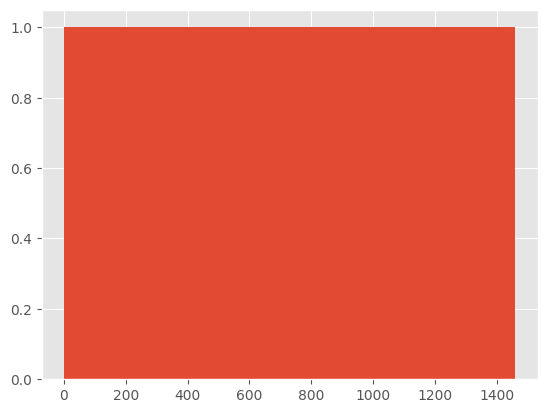

In [247]:
plt.hist(df["Id"], bins= len(df))

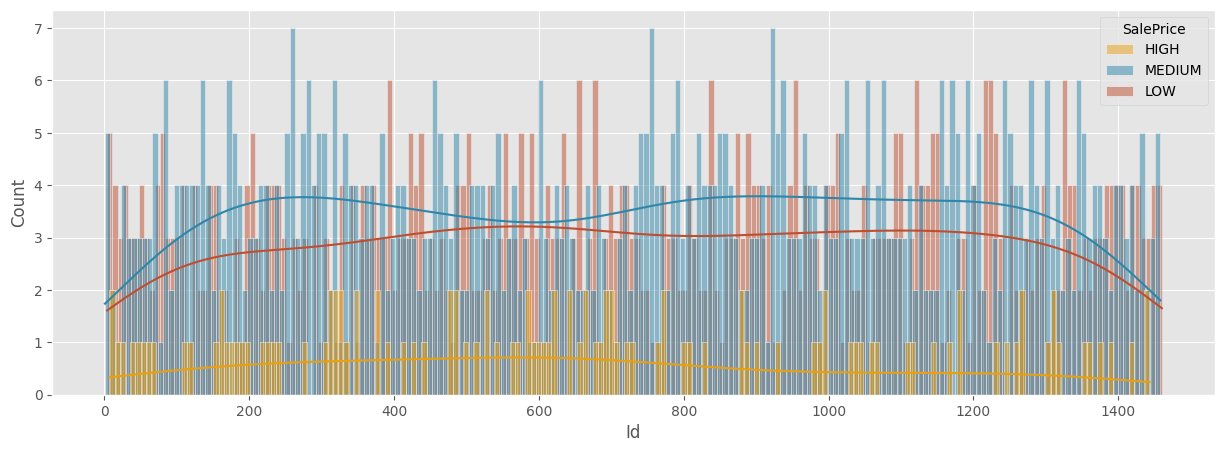

In [248]:
histplot(df,'SalePrice',"Id")

In [249]:
print("Max Entropy ( Log n ) -> " + str(math.log(len(df), 2)))

counts = df['Id'].value_counts()
probs = counts / len(df)
e = -np.sum(probs * np.log2(probs))
print("Entropy -> "+ str(e))

Max Entropy ( Log n ) -> 10.51175265376738
Entropy -> 10.511752653767381


##### MSSubClass

In [250]:
df["MSSubClass"] = df["MSSubClass"].astype("category")

SalePrice          LOW     MEDIUM       HIGH
MSSubClass                                  
20           43.097015  47.761194   9.141791
30           97.101449   2.898551   0.000000
40           50.000000  50.000000   0.000000
45          100.000000   0.000000   0.000000
50           72.222222  25.000000   2.777778
60            2.006689  80.936455  17.056856
70           45.000000  51.666667   3.333333
75           43.750000  43.750000  12.500000
80           29.310345  68.965517   1.724138
85           70.000000  30.000000   0.000000
90           82.692308  17.307692   0.000000
120          21.839080  71.264368   6.896552
160          58.730159  41.269841   0.000000
180         100.000000   0.000000   0.000000
190          76.666667  23.333333   0.000000

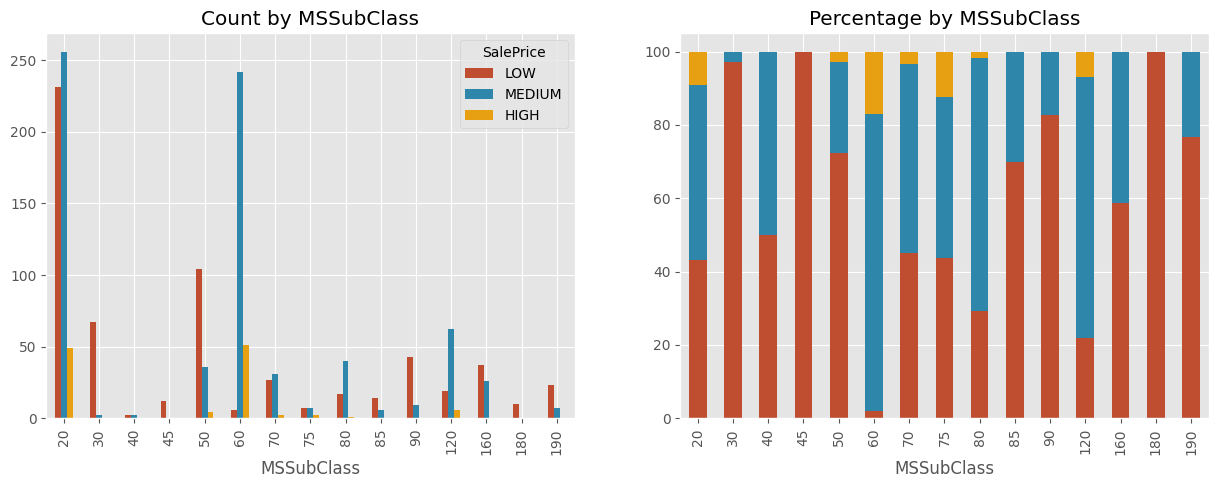

In [251]:
frequencies_and_percentages(df, 'SalePrice', 'MSSubClass')

In [252]:
IG(df,"SalePrice","MSSubClass")

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.28611883641757957

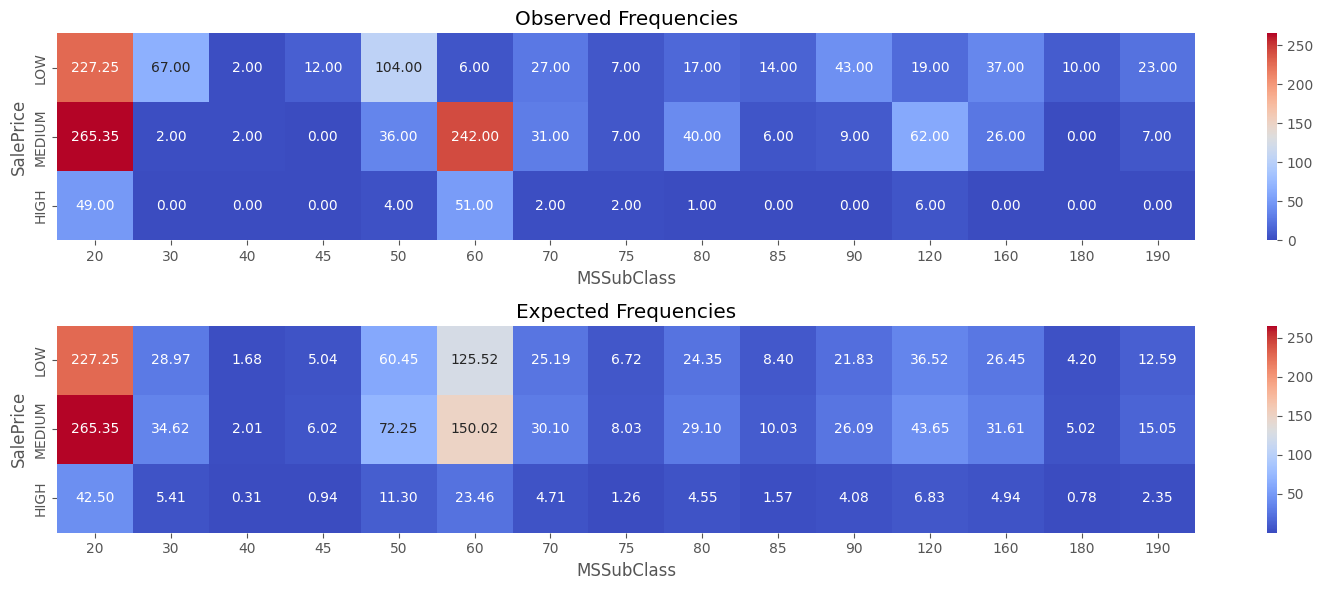

Chi-square Test - Outcome
P-Value: 1.122234664911419e-81 [<0.05]


(1.122234664911419e-81, '[<0.05]')

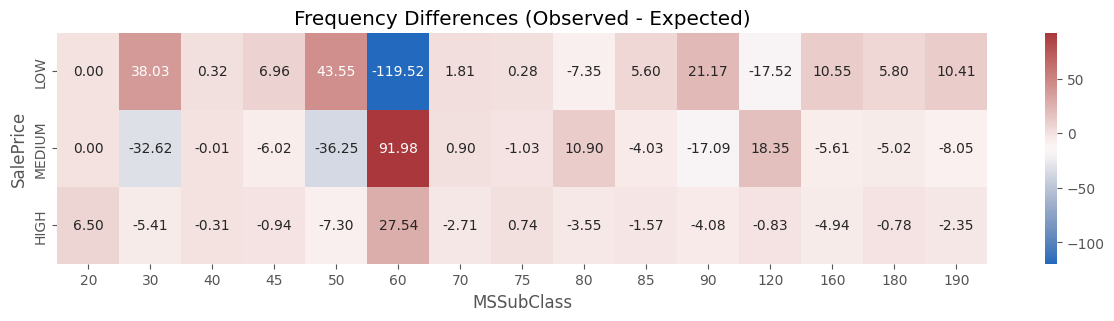

In [253]:
# Indepence test

stattest_quali(df, 'MSSubClass')

##### HouseStyle

SalePrice          LOW     MEDIUM       HIGH
HouseStyle                                  
1.5Fin       71.428571  25.974026   2.597403
1.5Unf      100.000000   0.000000   0.000000
1Story       47.382920  45.041322   7.575758
2.5Fin       25.000000  62.500000  12.500000
2.5Unf       63.636364  27.272727   9.090909
2Story       20.224719  67.865169  11.910112
SFoyer       78.378378  21.621622   0.000000
SLvl         35.384615  63.076923   1.538462

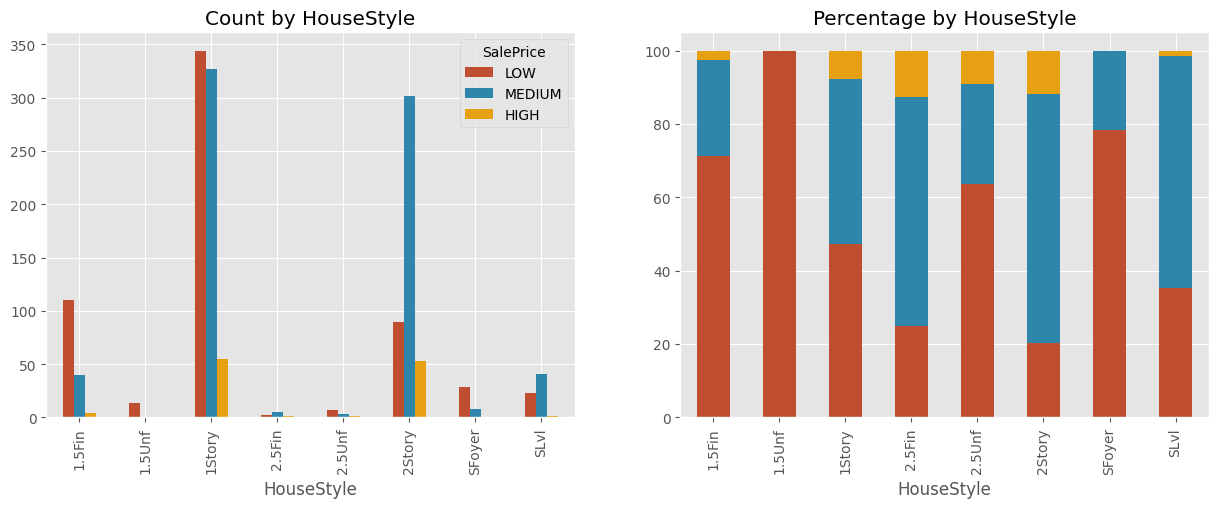

In [254]:
frequencies_and_percentages(df, 'SalePrice', 'HouseStyle')

##### MSZoning

In [255]:
df["MSZoning"] = df["MSZoning"].astype("category")

In [256]:
IG(df, "MSZoning", "SalePrice")


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.12336354296168264

<AxesSubplot: >

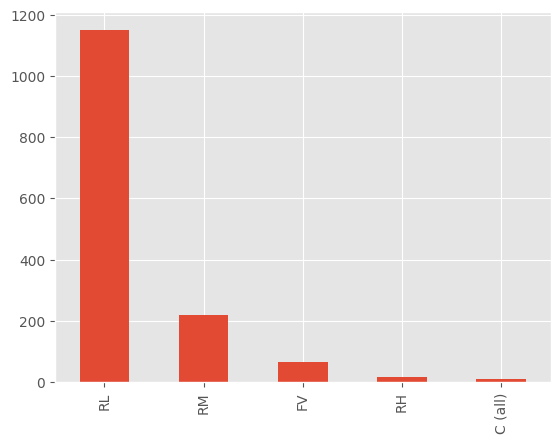

In [257]:
df["MSZoning"].value_counts().plot(kind="bar")

SalePrice         LOW     MEDIUM      HIGH
MSZoning                                  
C (all)    100.000000   0.000000  0.000000
FV           6.153846  84.615385  9.230769
RH          75.000000  25.000000  0.000000
RL          35.708080  55.082537  9.209383
RM          83.486239  15.137615  1.376147

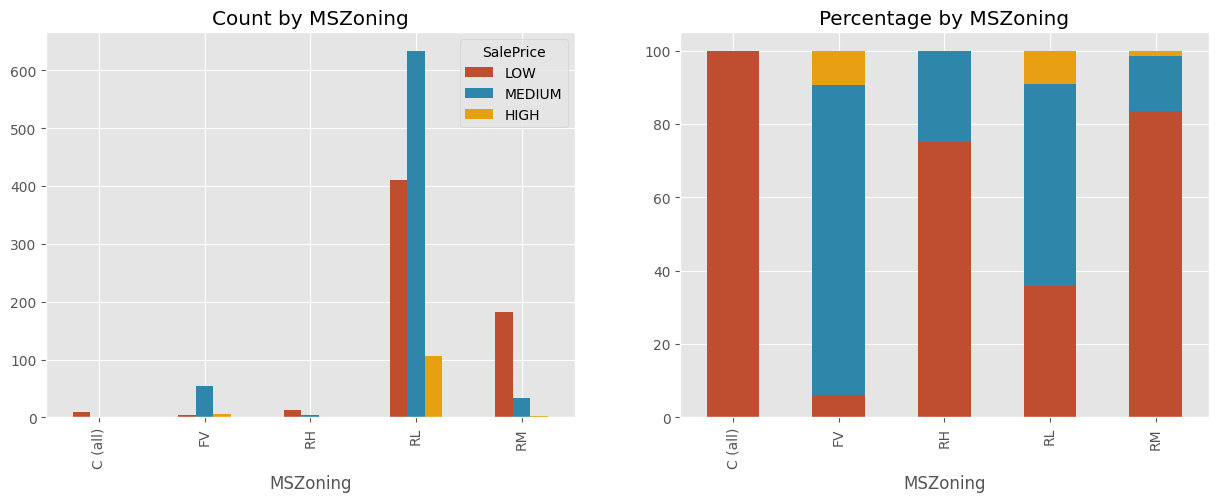

In [258]:
frequencies_and_percentages(df, 'SalePrice', 'MSZoning')

##### YearBuilt

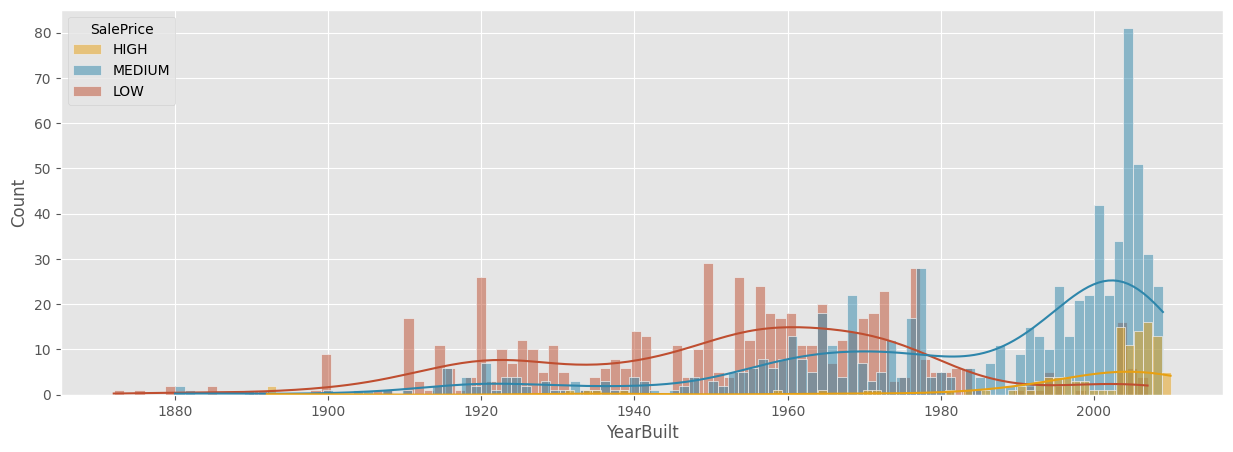

In [259]:
histplot(df,'SalePrice',"YearBuilt",bins=100)
    

ANOVA Test - Outcome
P-Value: 3.6397089066086615e-118 [<0.05]


(3.6397089066086615e-118, '[<0.05]')

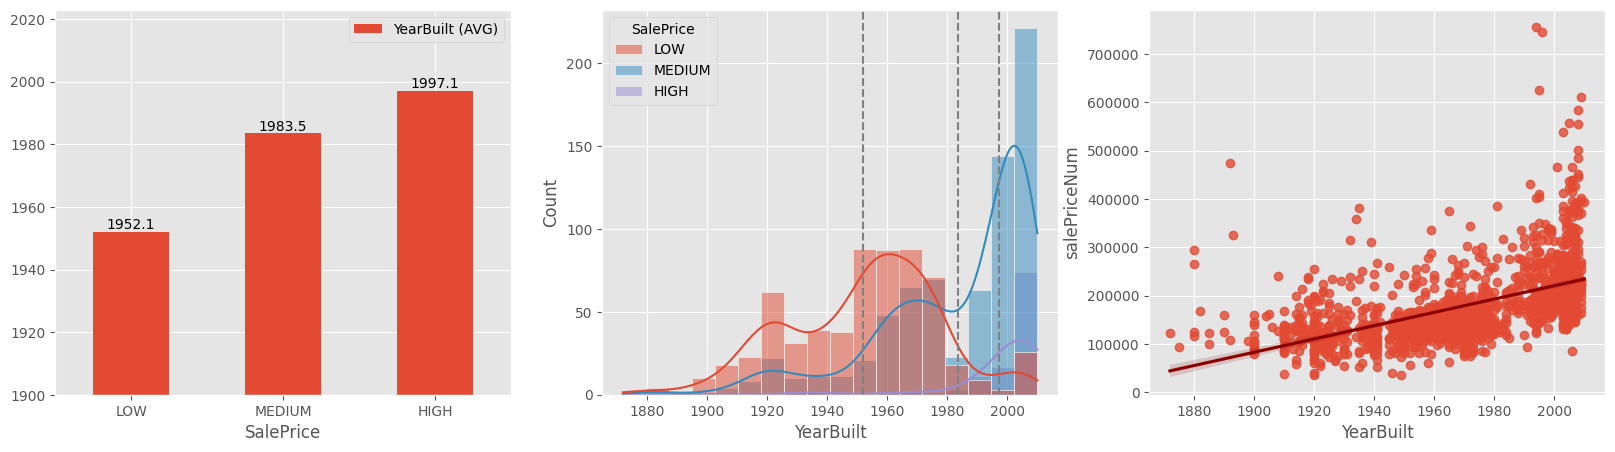

In [260]:
stattest_quanti(df,'YearBuilt', low_limit=1900, upper_limit=2023)

##### LotFrontage

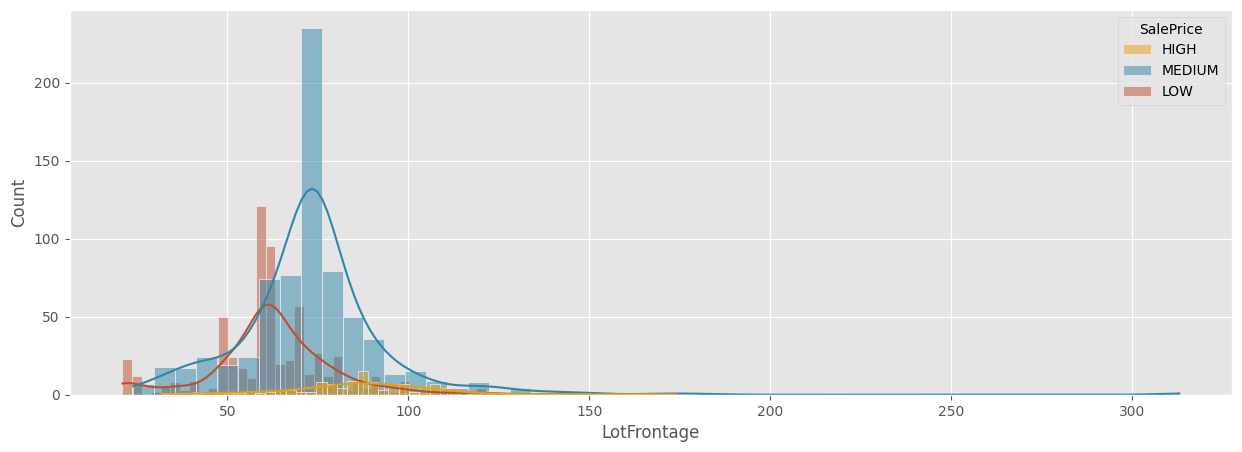

In [261]:
set_means(df,'LotFrontage')


histplot(df,'SalePrice',"LotFrontage", bins=50)


##### CentralAir

In [262]:
IG(df,'SalePrice','CentralAir')

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.05543545701641376

SalePrice         LOW     MEDIUM      HIGH
CentralAir                                
N           91.578947   8.421053  0.000000
Y           38.974359  52.600733  8.424908

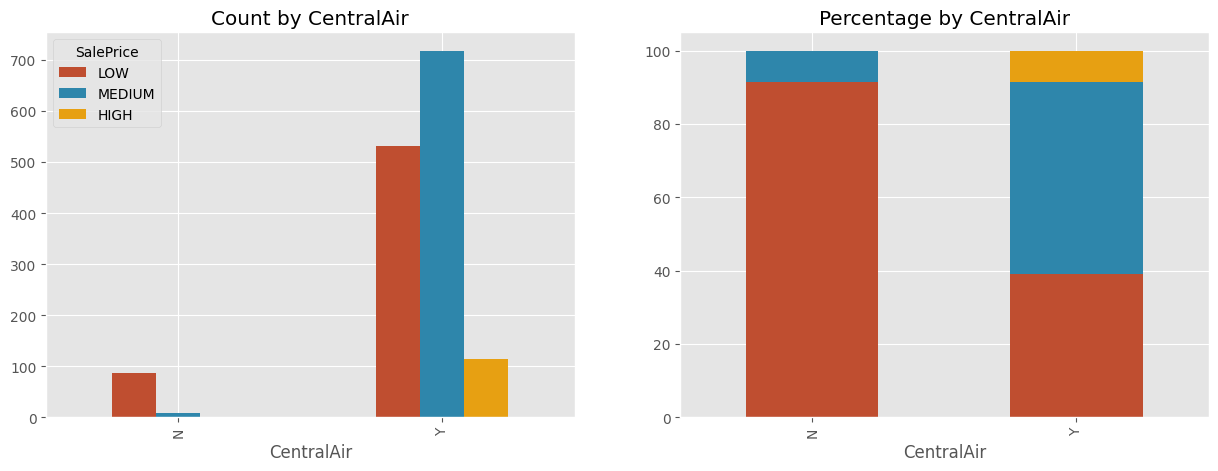

In [263]:
frequencies_and_percentages(df,'SalePrice','CentralAir')

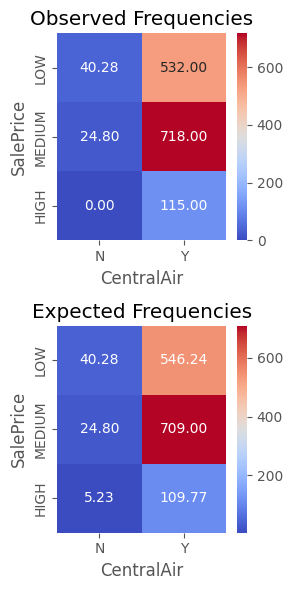

Chi-square Test - Outcome
P-Value: 1.2685848517032062e-22 [<0.05]


(1.2685848517032062e-22, '[<0.05]')

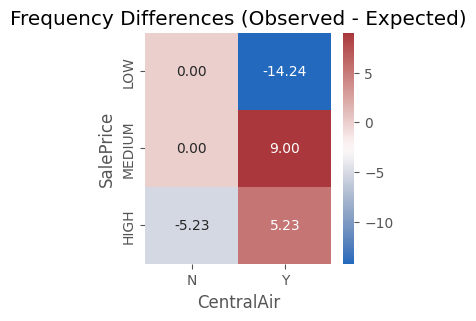

In [264]:
stattest_quali(df,'CentralAir', typeplot='heatmap', fig_width=10)

ANOVA Test - Outcome
P-Value: 7.00278021431306e-52 [<0.05]


(7.00278021431306e-52, '[<0.05]')

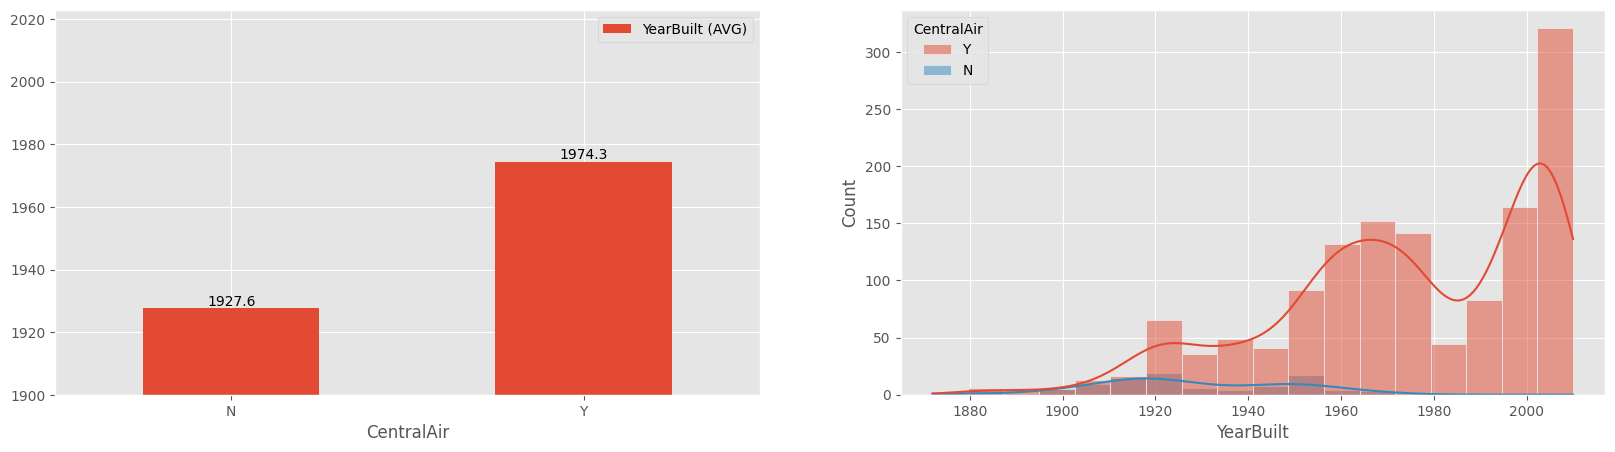

In [265]:
stattest_quanti(df,'YearBuilt', 'CentralAir' , low_limit=1900, upper_limit=2023)

##### Electrical

SalePrice          LOW      MEDIUM     HIGH
Electrical                                 
FuseA        81.914894   18.085106  0.00000
FuseF        96.296296    3.703704  0.00000
FuseP       100.000000    0.000000  0.00000
Mix         100.000000    0.000000  0.00000
NA            0.000000  100.000000  0.00000
SBrkr        38.380810   52.998501  8.62069

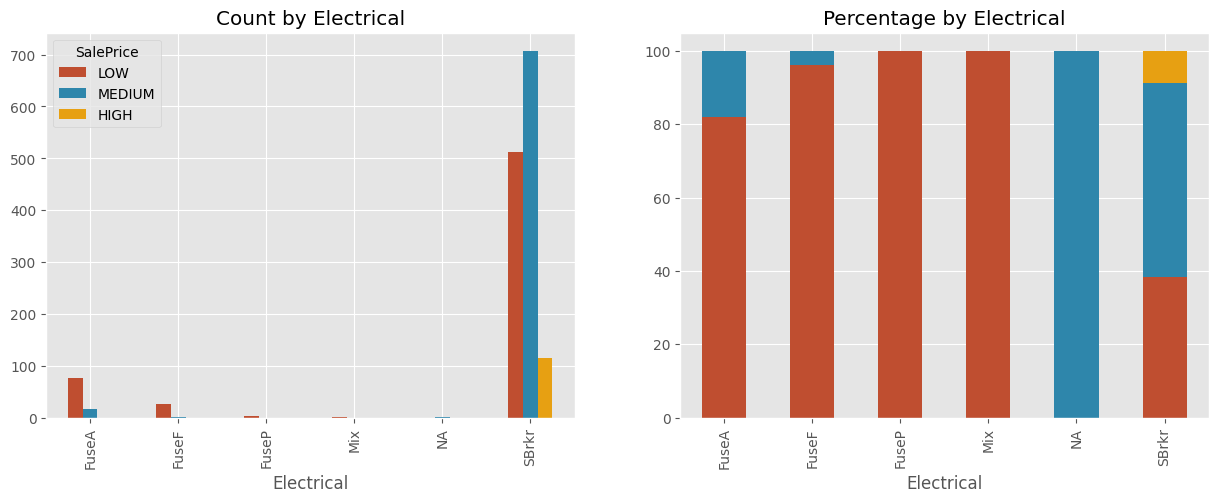

In [266]:
frequencies_and_percentages(df,'SalePrice','Electrical')

In [267]:
IG(df,'SalePrice','Electrical')

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.060141516515176664

In [268]:
len(df[df['Electrical'] == 'NA'])

1

##### 1stFlrSF

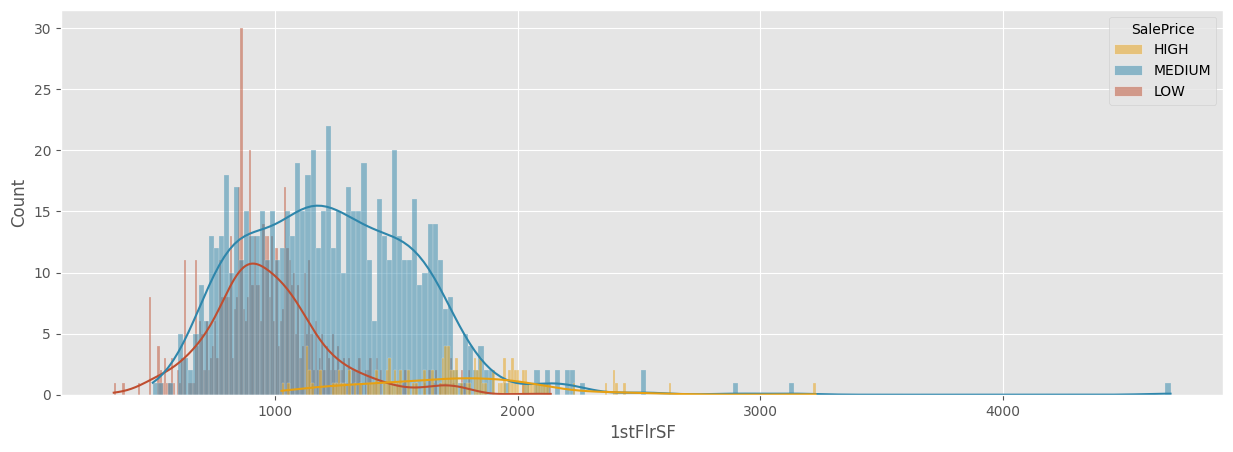

In [269]:
histplot(df,'SalePrice','1stFlrSF',bins=200)

ANOVA Test - Outcome
P-Value: 2.555821024618768e-104 [<0.05]


(2.555821024618768e-104, '[<0.05]')

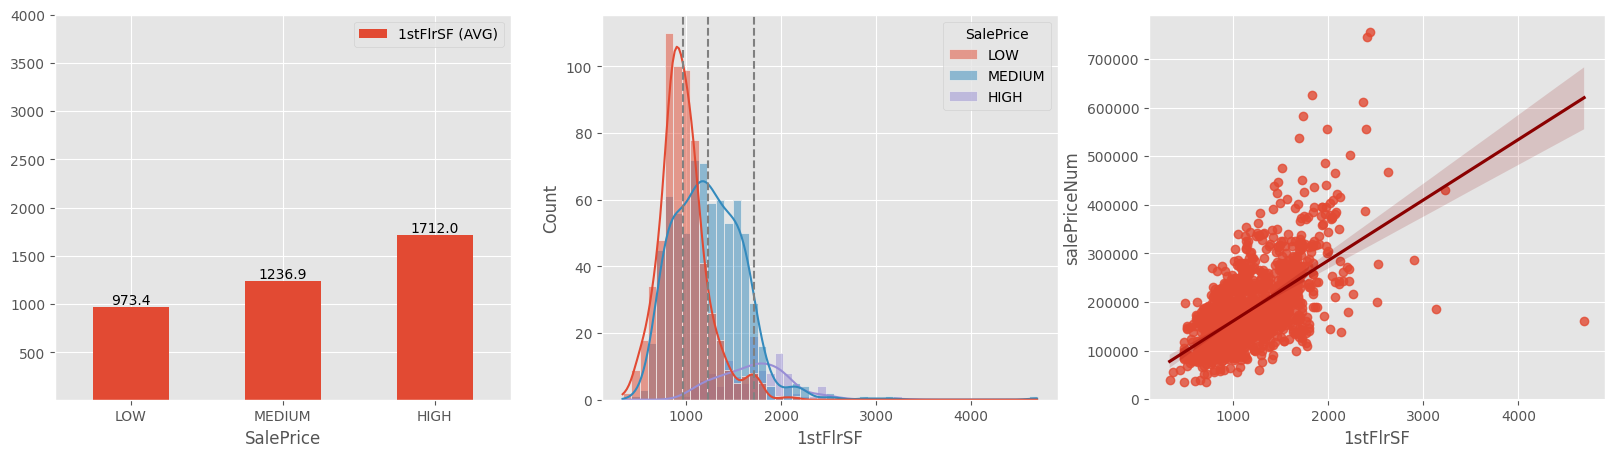

In [270]:
stattest_quanti(df,'1stFlrSF',low_limit=10, upper_limit=4000)

##### 2ndFlrSF


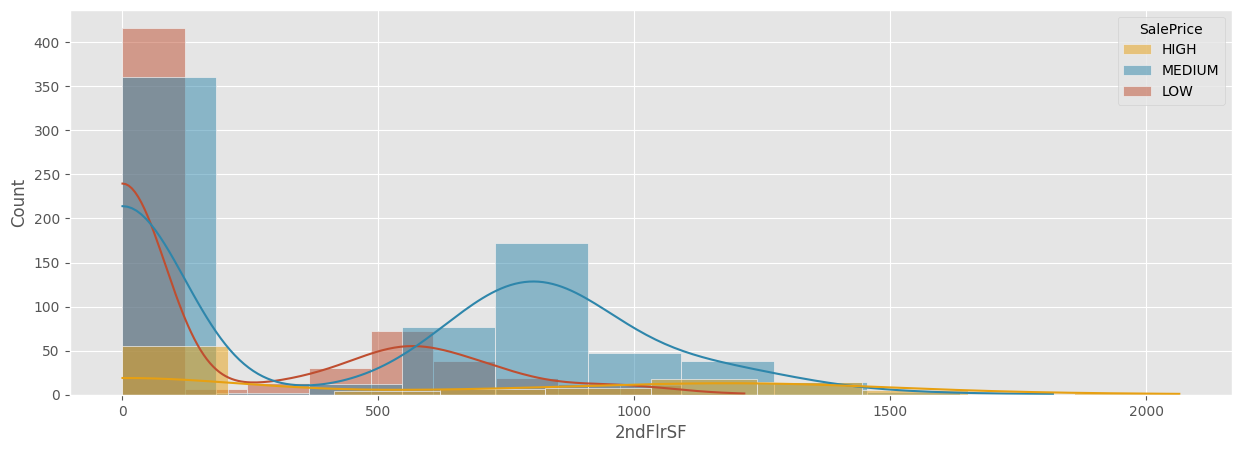

ANOVA Test - Outcome
P-Value: 1.7788644017519046e-32 [<0.05]


(1.7788644017519046e-32, '[<0.05]')

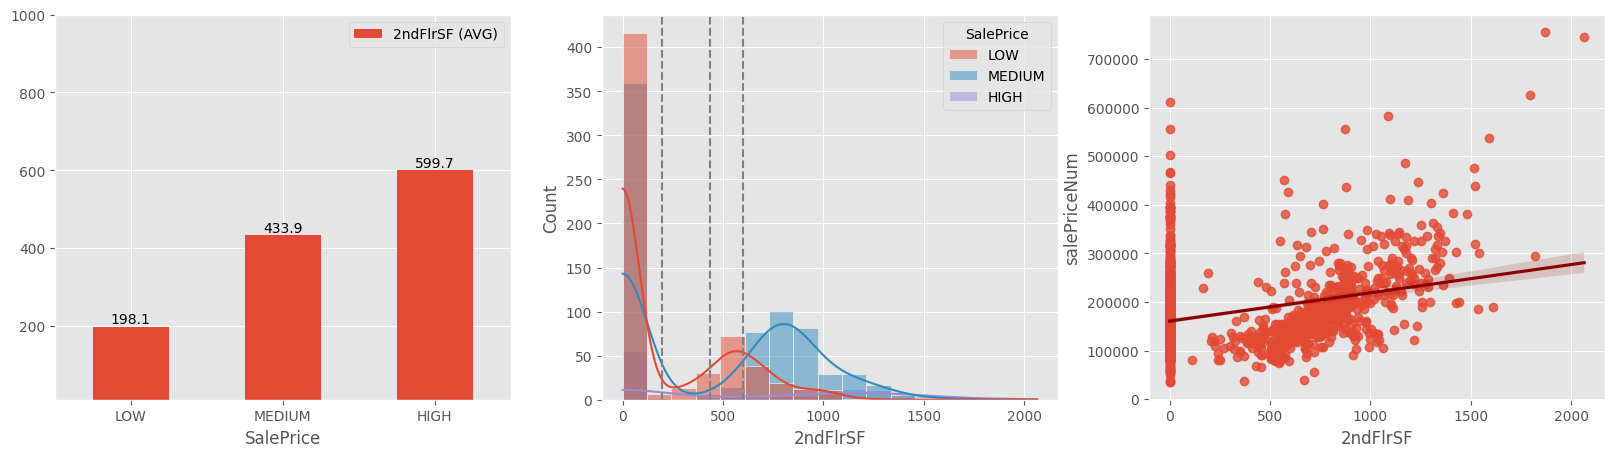

In [271]:
histplot(df,'SalePrice','2ndFlrSF',bins=10)
stattest_quanti(df,'2ndFlrSF',low_limit=10, upper_limit=1000)

##### LowQualFinSF

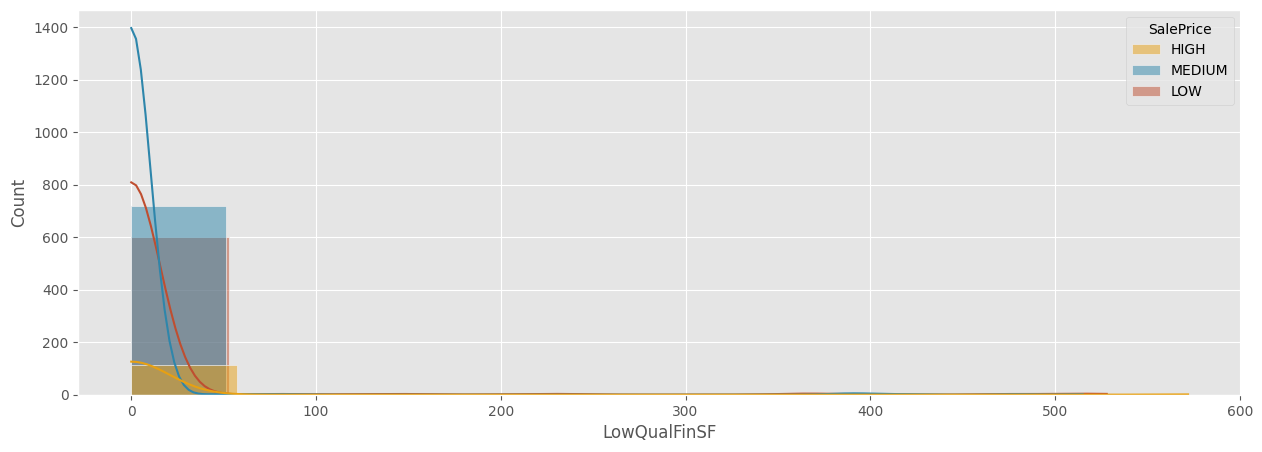

ANOVA Test - Outcome
P-Value: 0.20310425163833182 


(0.20310425163833182, '')

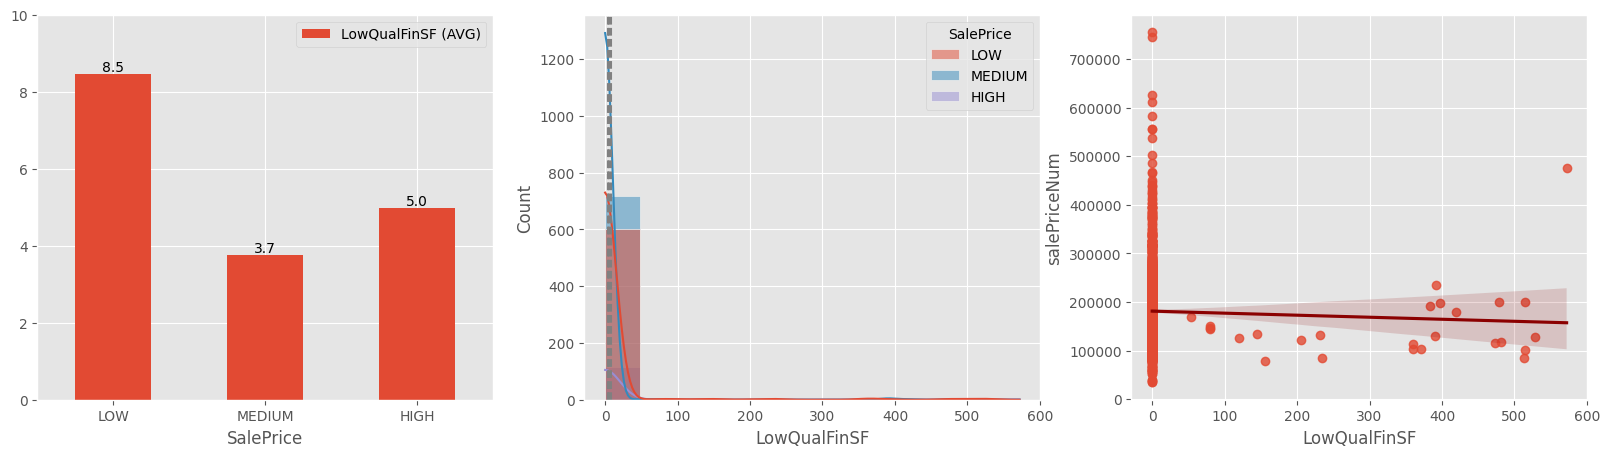

In [272]:
histplot(df,'SalePrice','LowQualFinSF',bins=10)
stattest_quanti(df,'LowQualFinSF',low_limit=0, upper_limit=10)

##### GrLivArea

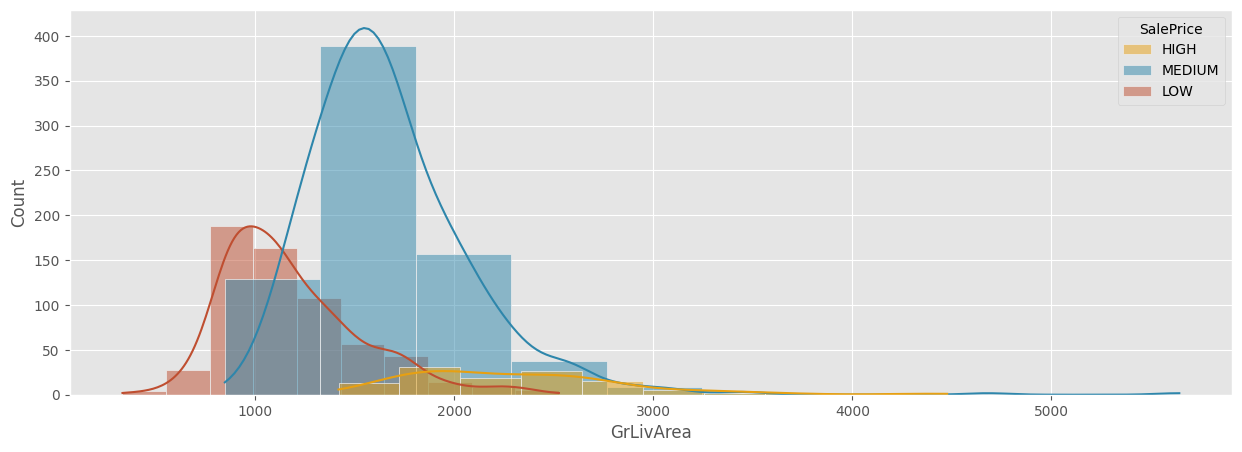

ANOVA Test - Outcome
P-Value: 2.727682408446856e-163 [<0.05]


(2.727682408446856e-163, '[<0.05]')

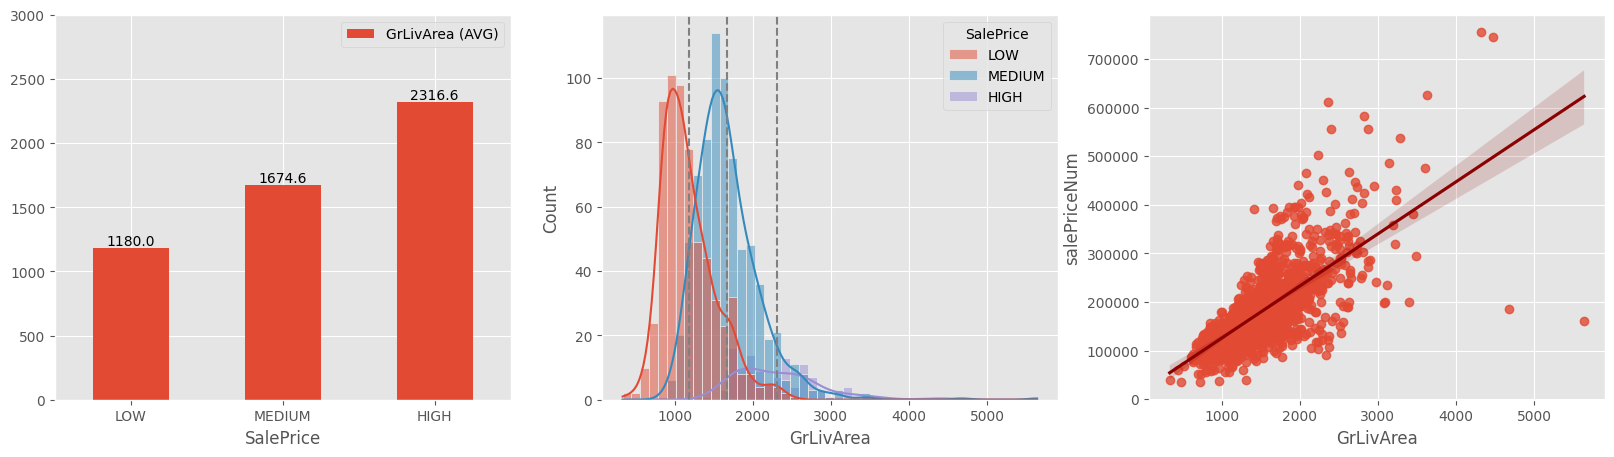

In [273]:
histplot(df,'SalePrice','GrLivArea',bins=10)
stattest_quanti(df,'GrLivArea',low_limit=0, upper_limit=3000)

##### BsmtFullBath

SalePrice             LOW      MEDIUM       HIGH
BsmtFullBath                                    
BsmtFullBath_0  48.130841   48.247664   3.621495
BsmtFullBath_1  34.353741   51.870748  13.775510
BsmtFullBath_2  33.333333   46.666667  20.000000
BsmtFullBath_3   0.000000  100.000000   0.000000

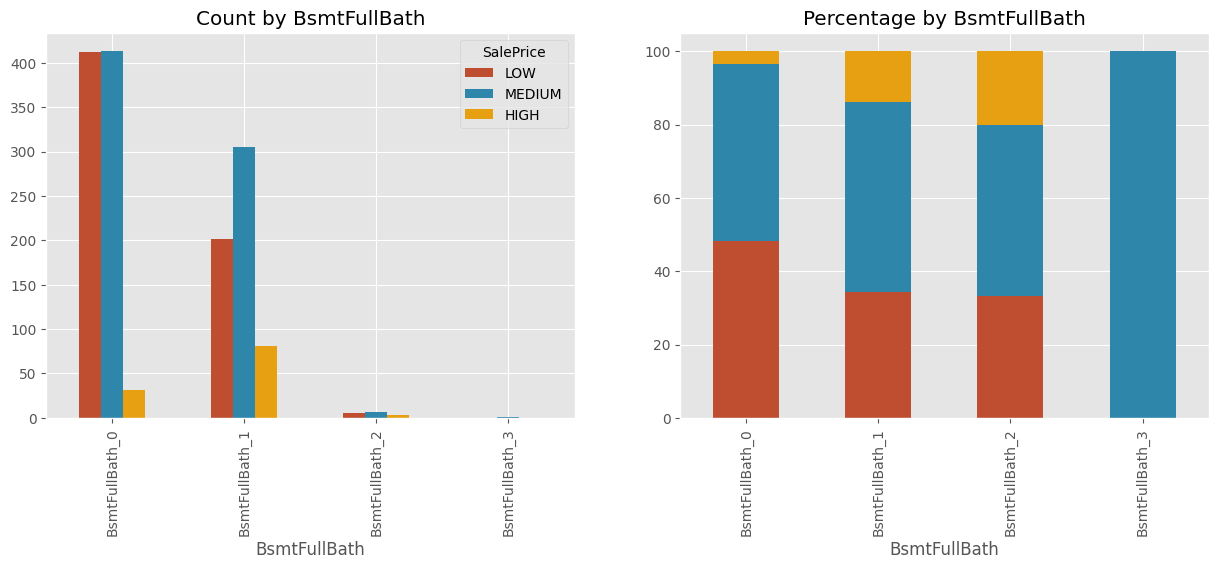

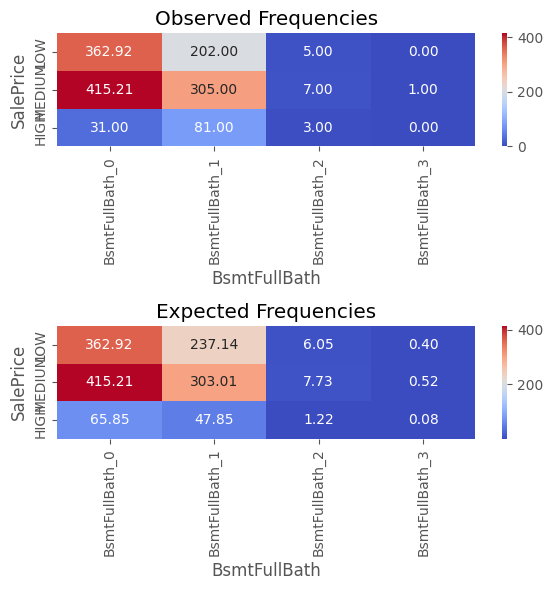

Chi-square Test - Outcome
P-Value: 2.3271572182731895e-12 [<0.05]
0.032819947247596126


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


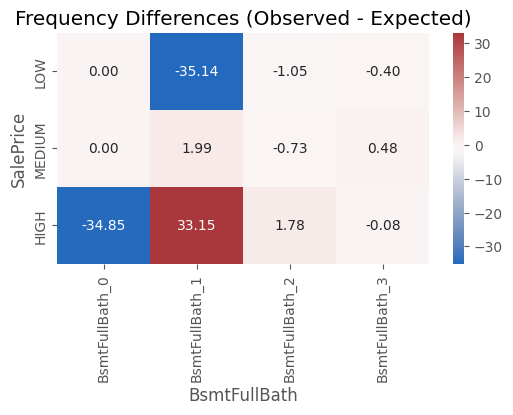

In [274]:
categoric_ordinal_plot(df, 'BsmtFullBath')

##### BsmtHalfBath

SalePrice             LOW     MEDIUM      HIGH
BsmtHalfBath                                  
BsmtHalfBath_0  42.380261  49.492017  8.127721
BsmtHalfBath_1  42.500000  53.750000  3.750000
BsmtHalfBath_2  50.000000  50.000000  0.000000

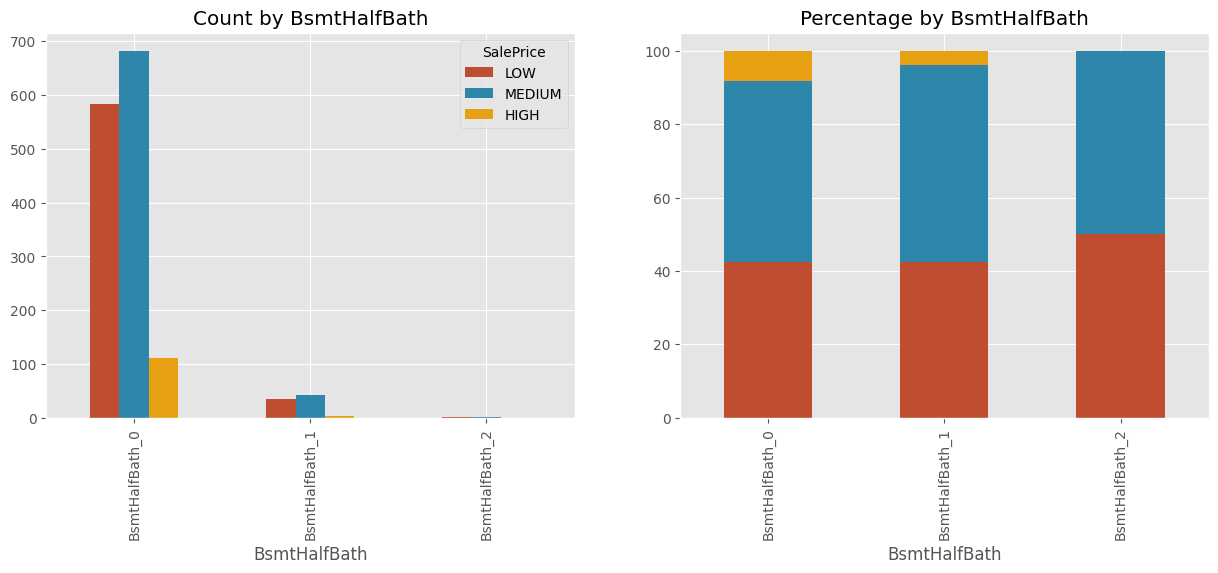

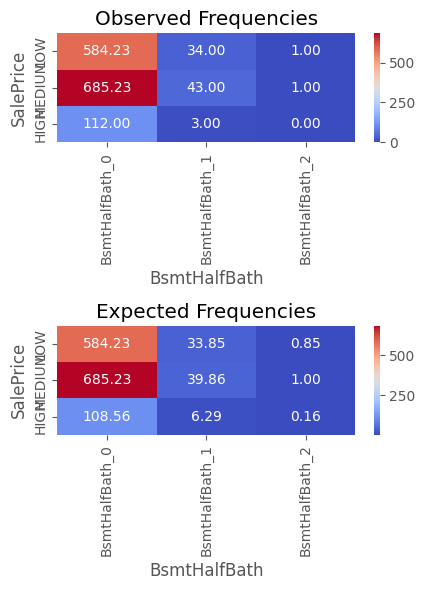

Chi-square Test - Outcome
P-Value: 0.6806487194877051 
0.0014174939544221248


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


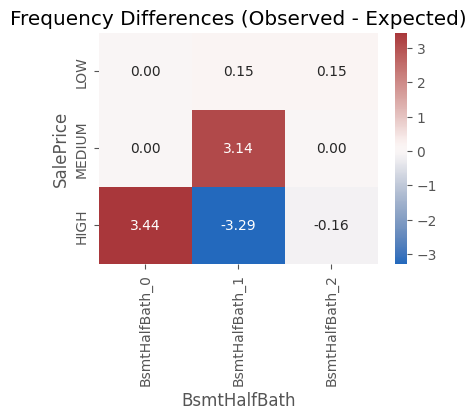

In [275]:
categoric_ordinal_plot(df, 'BsmtHalfBath')

##### FullBath

SalePrice         LOW     MEDIUM       HIGH
FullBath                                   
FullBath_0  55.555556  33.333333  11.111111
FullBath_1  74.923077  24.000000   1.076923
FullBath_2  16.536458  71.875000  11.588542
FullBath_3   0.000000  45.454545  54.545455

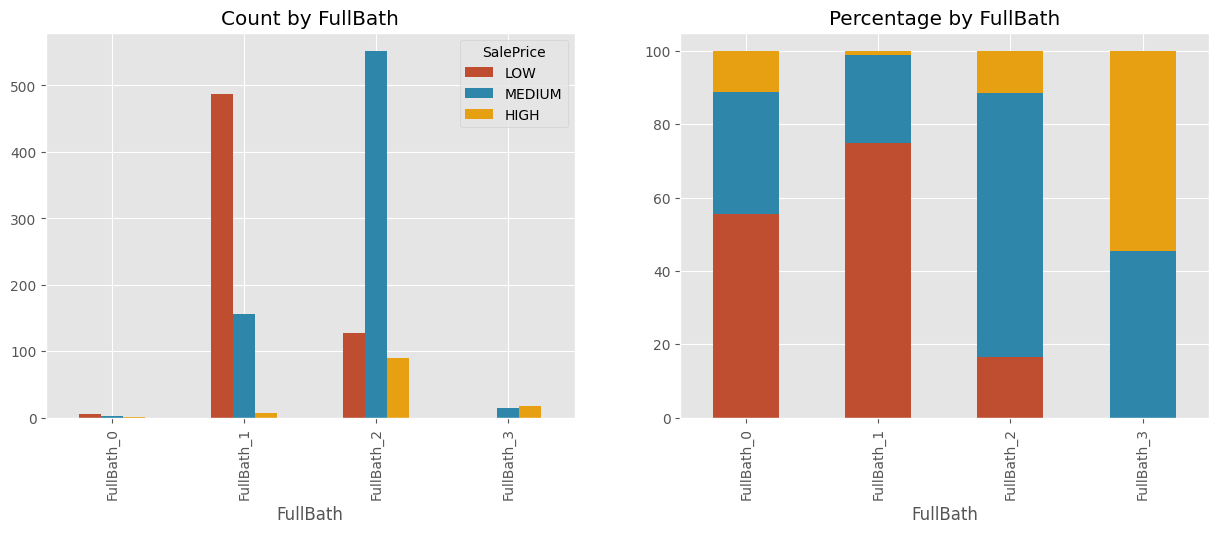

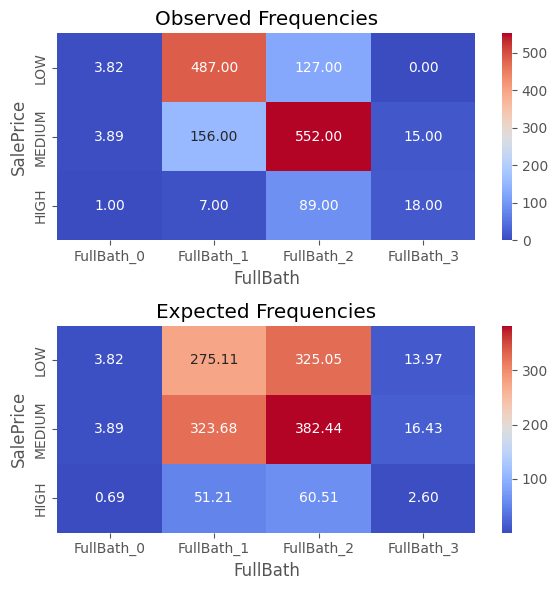

Chi-square Test - Outcome
P-Value: 4.018443251096999e-127 [<0.05]
0.29826715827233946


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.29826715827233946

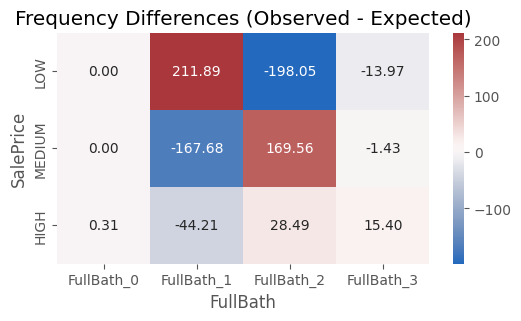

In [276]:
categoric_ordinal_plot(df, 'FullBath')
IG(df, TARGET_FEATURE, 'FullBath')

##### HalfBath

SalePrice         LOW     MEDIUM       HIGH
HalfBath                                   
HalfBath_0  55.969332  39.101862   4.928806
HalfBath_1  19.252336  67.663551  13.084112
HalfBath_2  41.666667  58.333333   0.000000

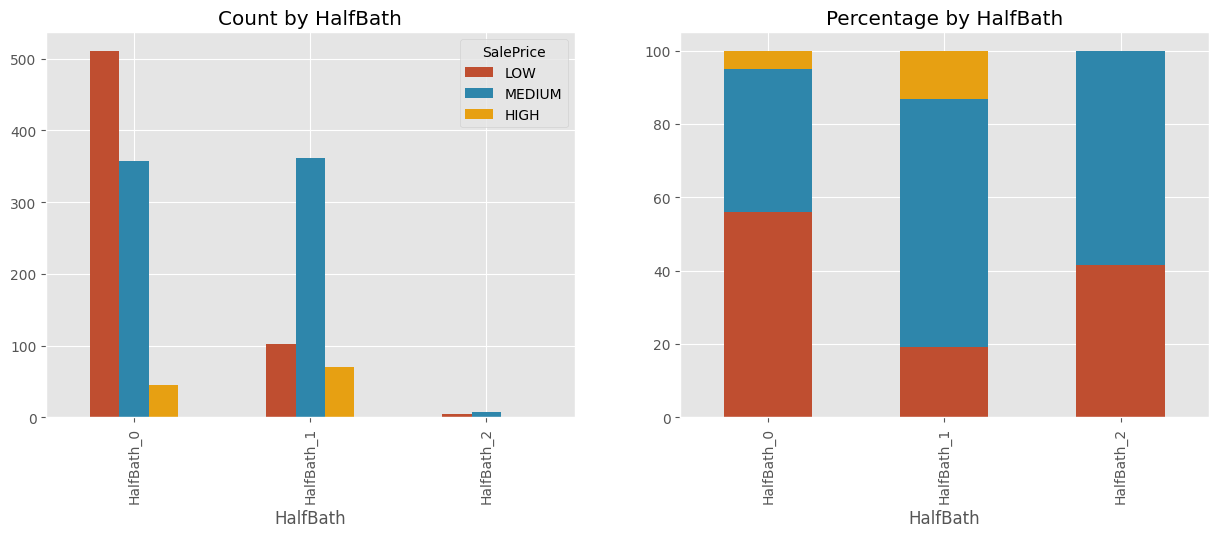

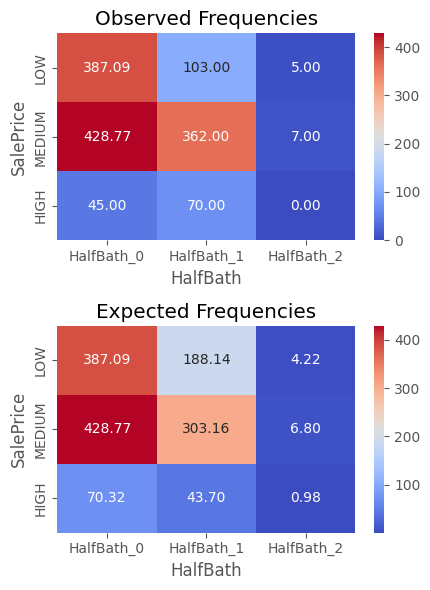

Chi-square Test - Outcome
P-Value: 1.7652372425300367e-40 [<0.05]
0.10054858198695393


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


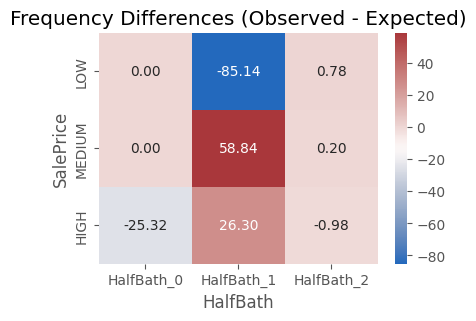

In [277]:
categoric_ordinal_plot(df, 'HalfBath')

##### BedroomAbvGr

SalePrice             LOW      MEDIUM       HIGH
BedroomAbvGr                                    
BedroomAbvGr_0  50.000000   33.333333  16.666667
BedroomAbvGr_1  56.000000   32.000000  12.000000
BedroomAbvGr_2  59.497207   34.357542   6.145251
BedroomAbvGr_3  37.064677   57.089552   5.845771
BedroomAbvGr_4  30.046948   52.582160  17.370892
BedroomAbvGr_5  33.333333   57.142857   9.523810
BedroomAbvGr_6  85.714286   14.285714   0.000000
BedroomAbvGr_8   0.000000  100.000000   0.000000

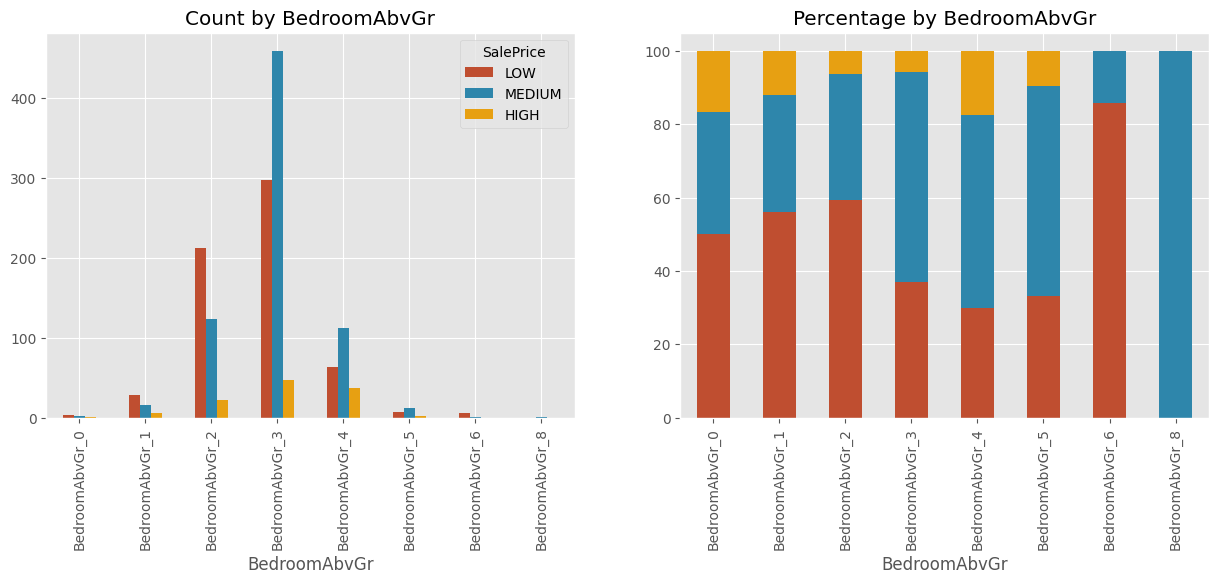

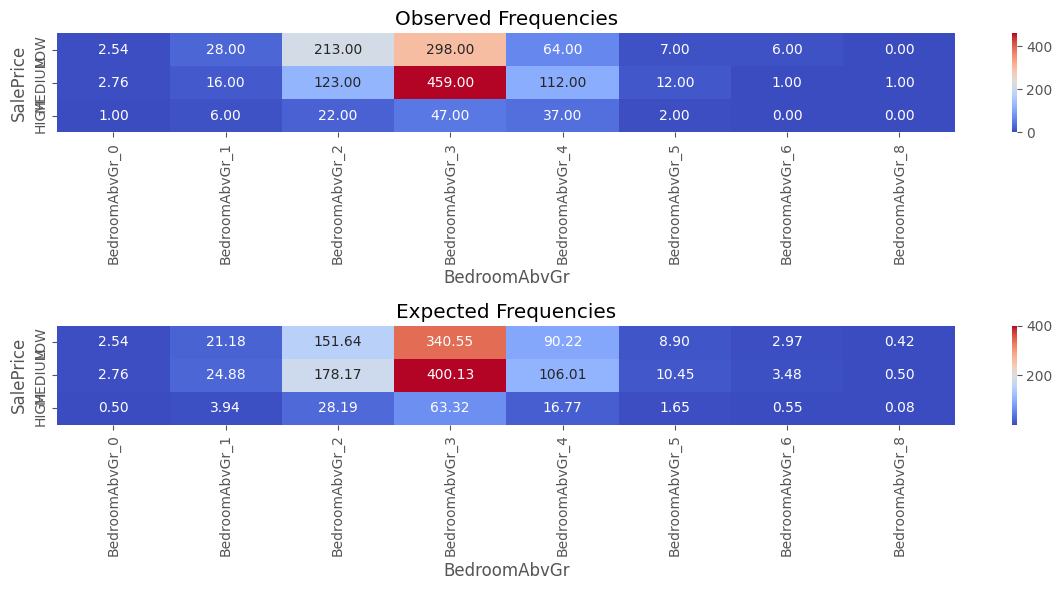

Chi-square Test - Outcome
P-Value: 1.1574262089106492e-16 [<0.05]
0.05116755634206285


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


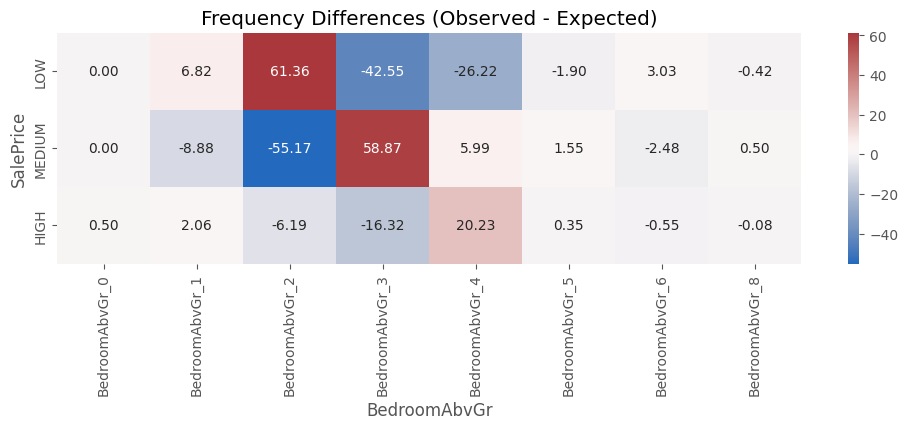

In [278]:
categoric_ordinal_plot(df, 'BedroomAbvGr')

##### KitchenAbvGr

SalePrice              LOW     MEDIUM      HIGH
KitchenAbvGr                                   
KitchenAbvGr_0  100.000000   0.000000  0.000000
KitchenAbvGr_1   40.517241  51.221264  8.261494
KitchenAbvGr_2   80.000000  20.000000  0.000000
KitchenAbvGr_3  100.000000   0.000000  0.000000

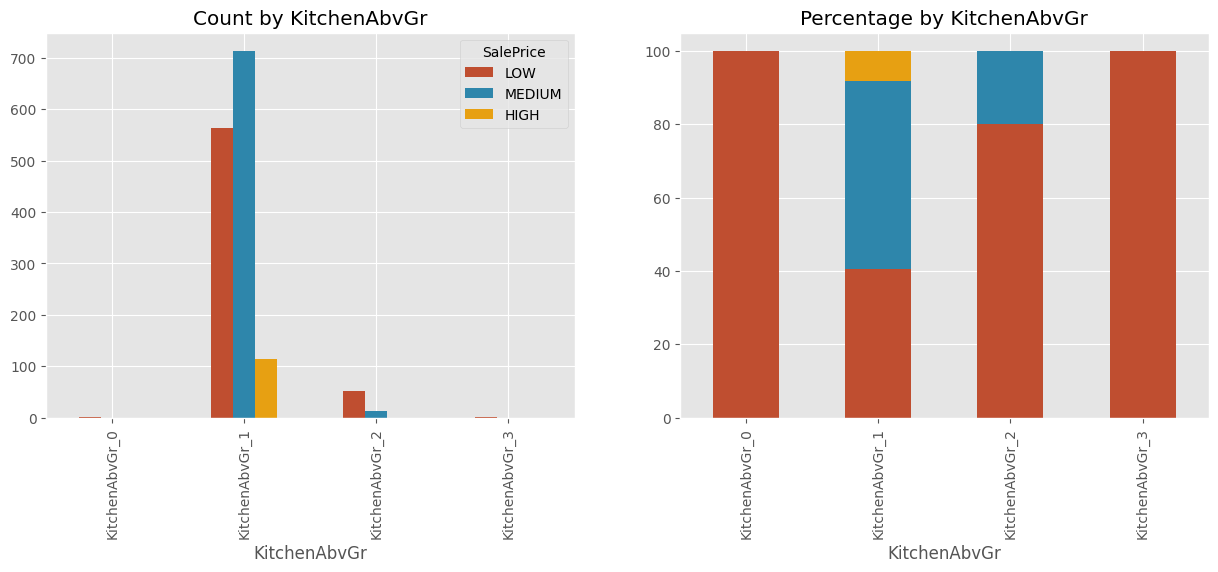

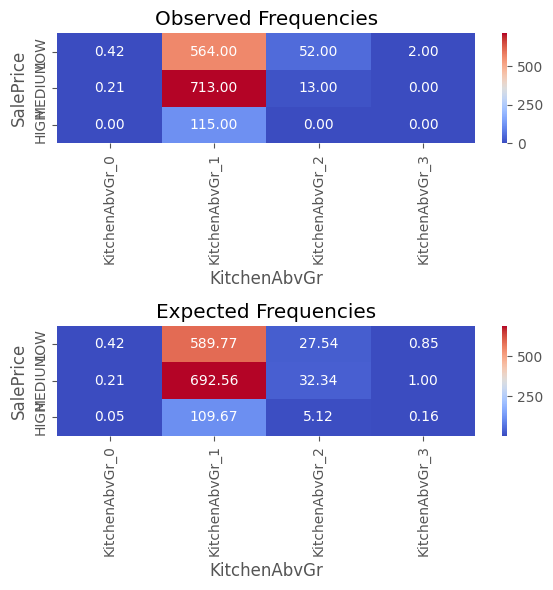

Chi-square Test - Outcome
P-Value: 5.958096086434347e-08 [<0.05]
0.024484826808309997


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


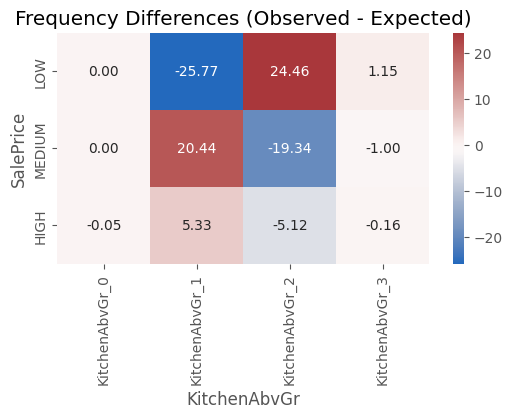

In [279]:
categoric_ordinal_plot(df, 'KitchenAbvGr')

##### KitchenQual

SalePrice          LOW     MEDIUM       HIGH
KitchenQual                                 
Ex            5.000000  38.000000  57.000000
Fa           94.871795   5.128205   0.000000
Gd           14.846416  75.597270   9.556314
TA           66.666667  33.061224   0.272109

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3341239388726758

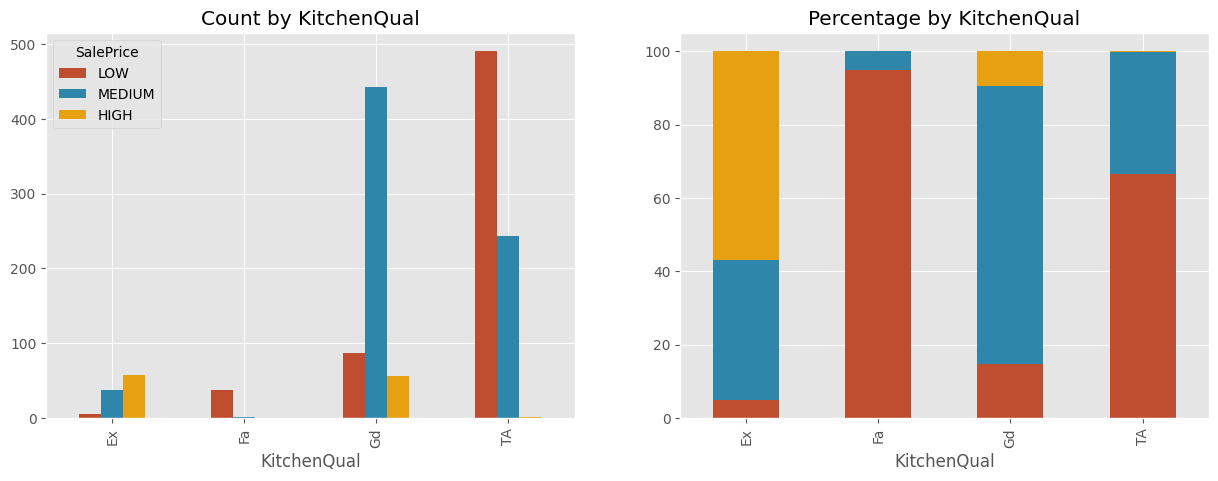

In [280]:
frequencies_and_percentages(df, TARGET_FEATURE, 'KitchenQual')
IG(df, TARGET_FEATURE, 'KitchenQual')

##### TotRmsAbvGrd

SalePrice            LOW      MEDIUM       HIGH
TotRmsAbvGrd                                   
2             100.000000    0.000000   0.000000
3              94.117647    5.882353   0.000000
4              83.505155   16.494845   0.000000
5              70.545455   27.636364   1.818182
6              46.268657   51.990050   1.741294
7              22.796353   70.212766   6.990881
8              21.390374   64.171123  14.438503
9              16.000000   58.666667  25.333333
10             21.276596   34.042553  44.680851
11             16.666667   27.777778  55.555556
12              9.090909   63.636364  27.272727
14              0.000000  100.000000   0.000000

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ANOVA Test - Outcome
P-Value: 4.972682537673768e-83 [<0.05]


(4.972682537673768e-83, '[<0.05]')

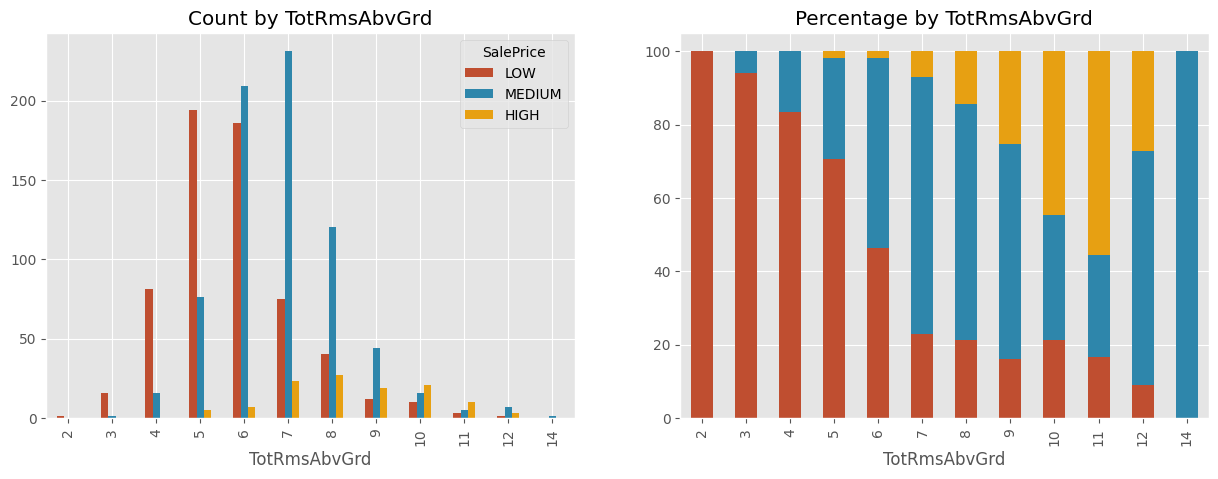

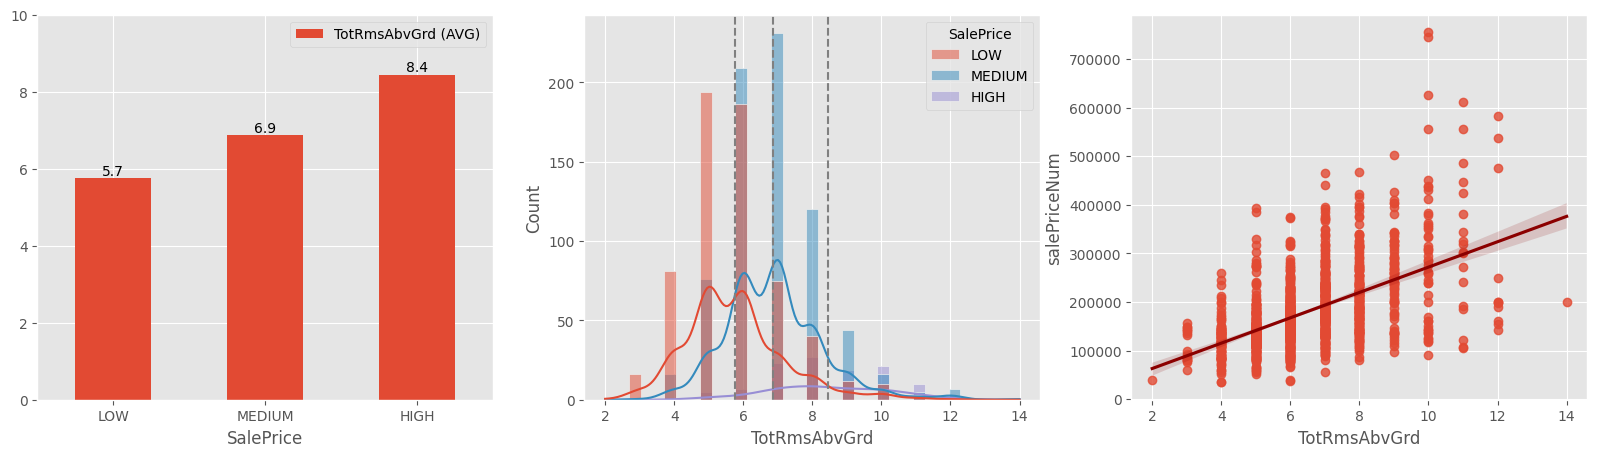

In [281]:
frequencies_and_percentages(df, TARGET_FEATURE, 'TotRmsAbvGrd')
IG(df, TARGET_FEATURE, 'TotRmsAbvGrd')
stattest_quanti(df, 'TotRmsAbvGrd', upper_limit=10)

##### Functional

SalePrice          LOW     MEDIUM      HIGH
Functional                                 
Maj1         57.142857  35.714286  7.142857
Maj2        100.000000   0.000000  0.000000
Min1         61.290323  38.709677  0.000000
Min2         61.764706  35.294118  2.941176
Mod          53.333333  40.000000  6.666667
Sev         100.000000   0.000000  0.000000
Typ          40.955882  50.808824  8.235294

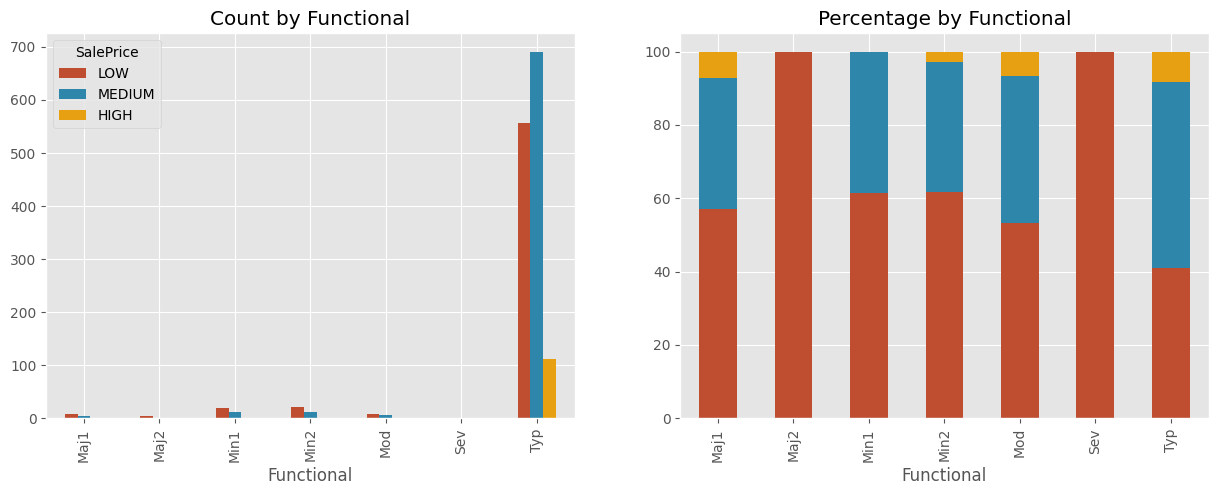

In [282]:
df_copy['Functional'] = df_copy['Functional'].astype('category')
#df_copy['Functional'].unique()
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'Functional')
#stattest_quali(df_copy, 'Functional')

##### Fireplaces

SalePrice           LOW     MEDIUM       HIGH
Fireplaces                                   
Fireplaces_0  66.956522  32.463768   0.579710
Fireplaces_1  21.384615  65.846154  12.769231
Fireplaces_2  15.652174  61.739130  22.608696
Fireplaces_3   0.000000  60.000000  40.000000

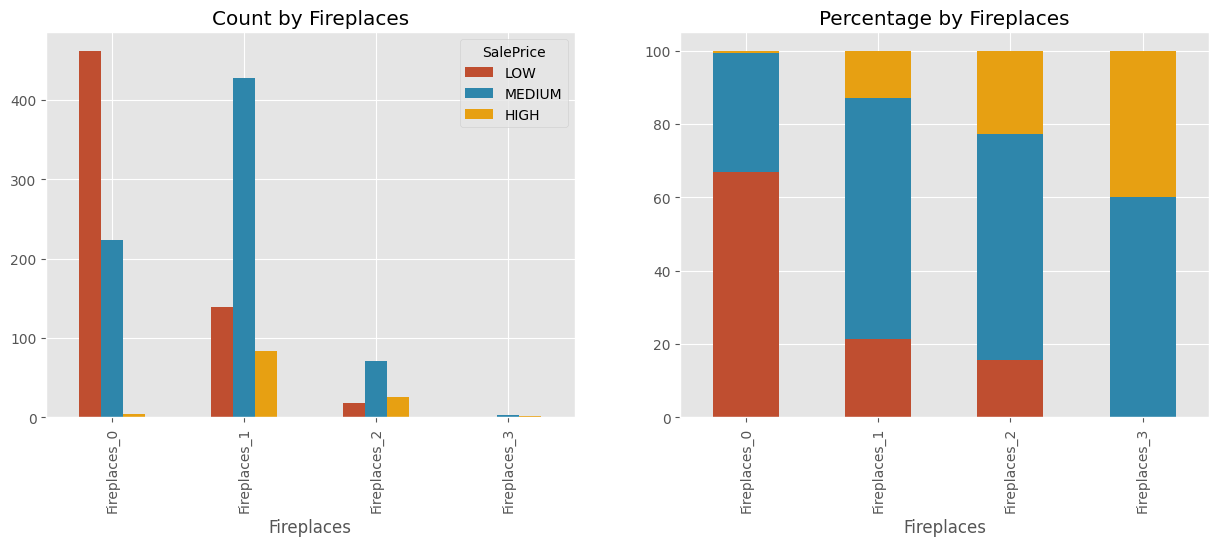

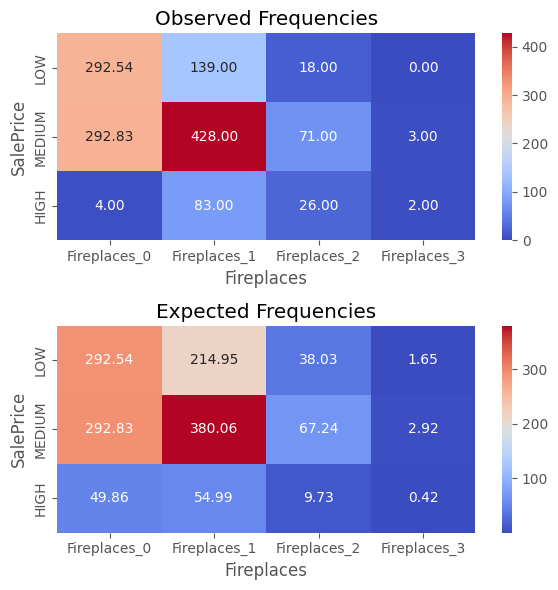

/tmp/ipykernel_8420/959702603.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = dataset.reset_index().groupby([feature_name, TARGET_FEATURE]).sum()


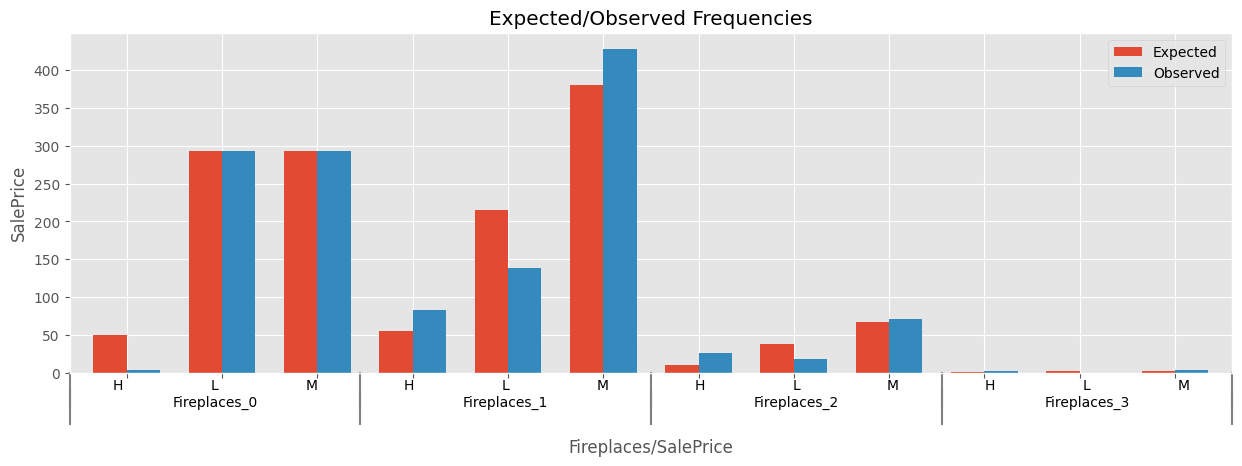

Chi-square Test - Outcome
P-Value: 5.349369497530157e-77 [<0.05]
0.1966071830585545


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [283]:
categoric_ordinal_plot(df, 'Fireplaces', test_typeplot='barplot')

##### FireplaceQu

SalePrice          LOW     MEDIUM       HIGH
FireplaceQu                                 
Ex            4.166667  33.333333  62.500000
Fa           36.363636  63.636364   0.000000
Gd           21.052632  60.526316  18.421053
NA           66.956522  32.463768   0.579710
Po           75.000000  25.000000   0.000000
TA           15.654952  76.038339   8.306709

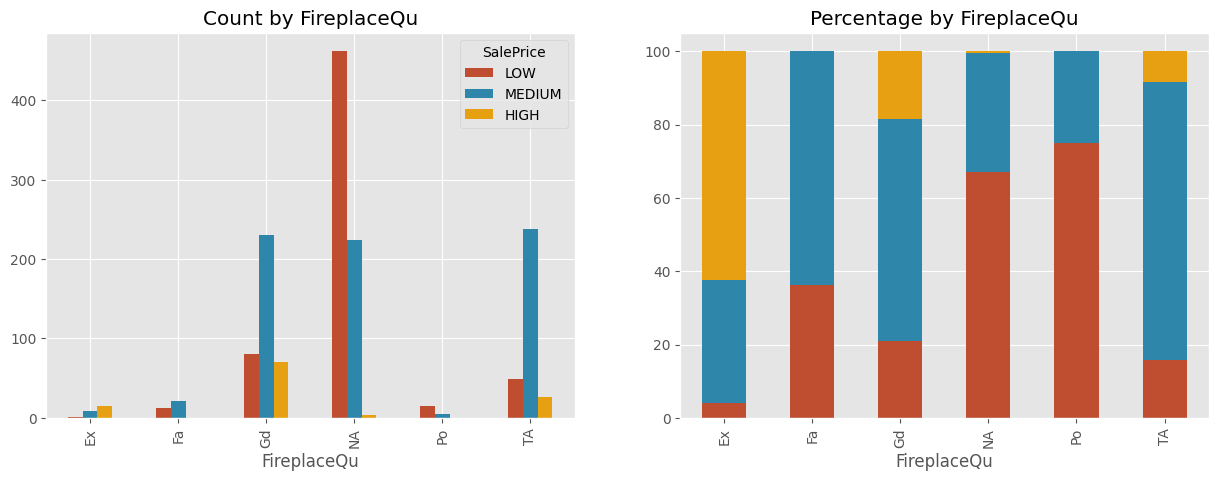

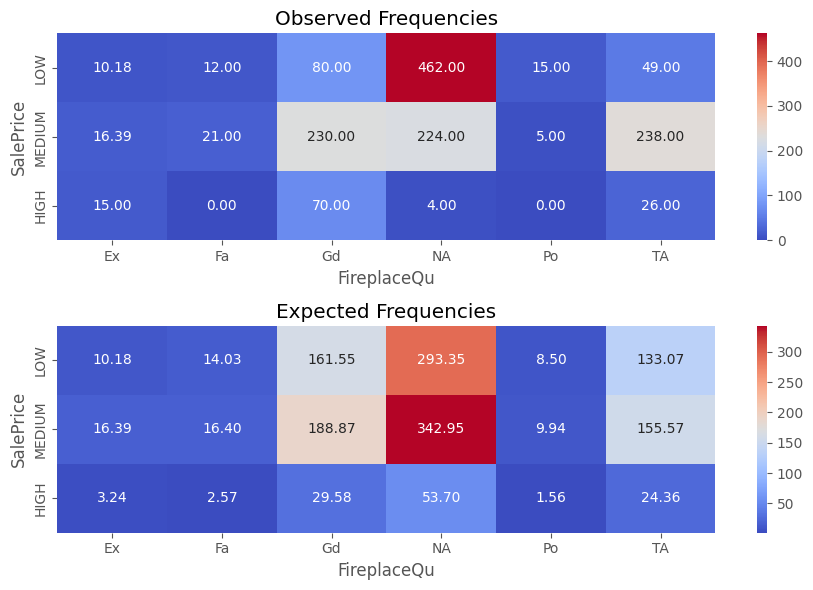

Chi-square Test - Outcome
P-Value: 5.148137174516188e-101 [<0.05]


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2386235241672774

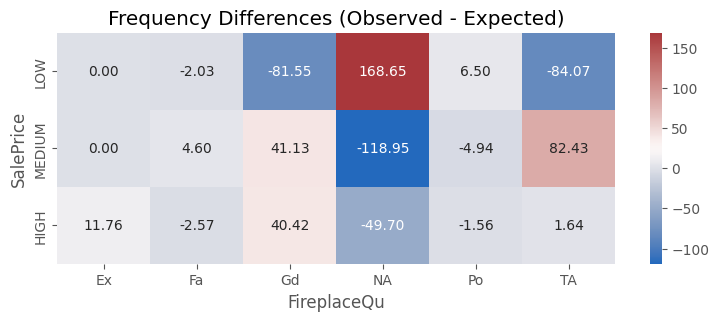

In [284]:
df_copy['FireplaceQu'] = df_copy['FireplaceQu'].astype('category')
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'FireplaceQu')
stattest_quali(df_copy, 'FireplaceQu')
IG(df_copy, TARGET_FEATURE, 'FireplaceQu')

##### GarageType

SalePrice         LOW     MEDIUM       HIGH
GarageType                                 
2Types      50.000000  50.000000   0.000000
Attchd      25.172414  64.597701  10.229885
Basment     52.631579  42.105263   5.263158
BuiltIn      7.954545  67.045455  25.000000
CarPort     88.888889  11.111111   0.000000
Detchd      76.227390  22.997416   0.775194
NA          95.061728   4.938272   0.000000

/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2403532227920979

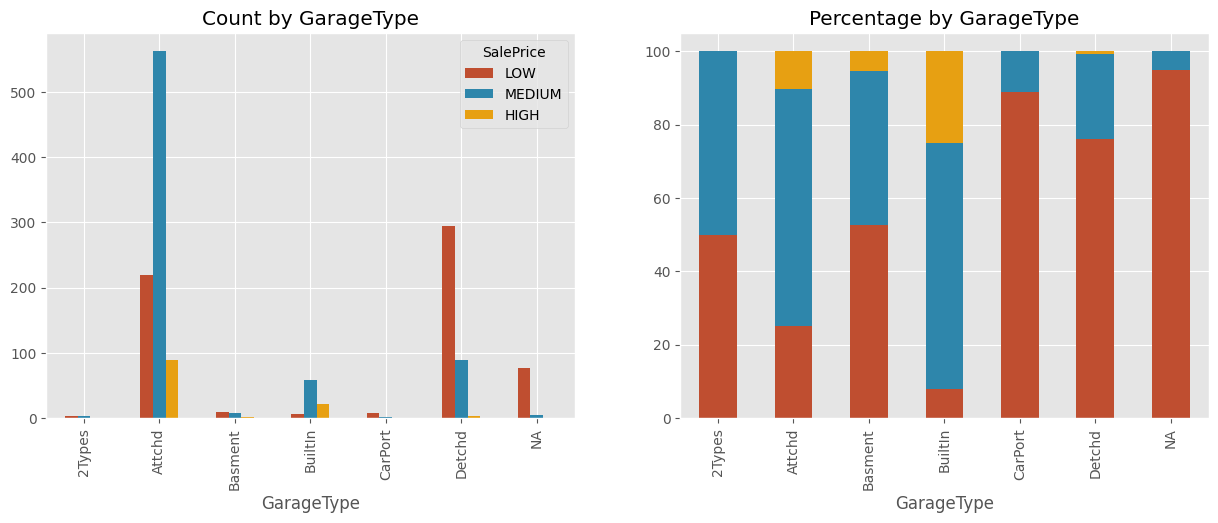

In [285]:
df['GarageType'].unique()
frequencies_and_percentages(df, TARGET_FEATURE, 'GarageType')
IG(df, TARGET_FEATURE, 'GarageType')

##### GarageYrBlt

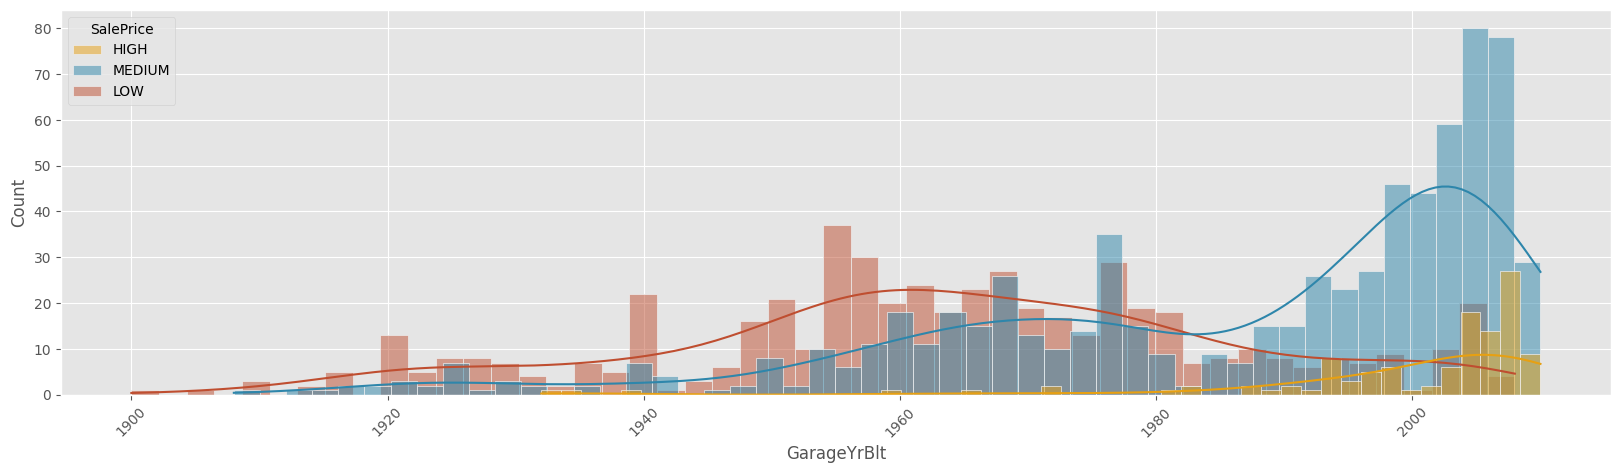

0.8256674841743443 0.0
0.4863616774878614 8.705127942139745e-83


(0.4863616774878614, 8.705127942139745e-83)

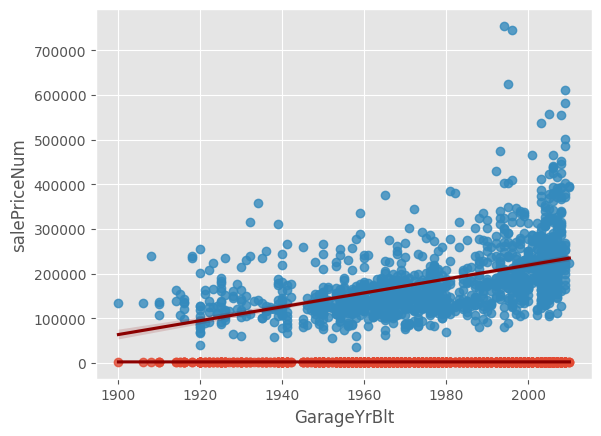

In [286]:
df_copy = df_copy.drop(df_copy[df_copy['GarageYrBlt'] == 'NA'].index)
df_copy['GarageYrBlt'] = df_copy['GarageYrBlt'].astype("int64")

histplot(df_copy, TARGET_FEATURE, 'GarageYrBlt', figsize=(20, 5), xticks_rot=45, bins=50)
correlation(df_copy, 'GarageYrBlt', 'YearBuilt')
correlation(df_copy, 'GarageYrBlt', TARGET_FEATURE_CONTI)

##### GarageFinish

['RFn' 'Unf' 'Fin' 'NA']


SalePrice           LOW     MEDIUM       HIGH
GarageFinish                                 
Fin           11.079545  66.761364  22.159091
NA            95.061728   4.938272   0.000000
RFn           18.957346  74.407583   6.635071
Unf           69.917355  28.595041   1.487603

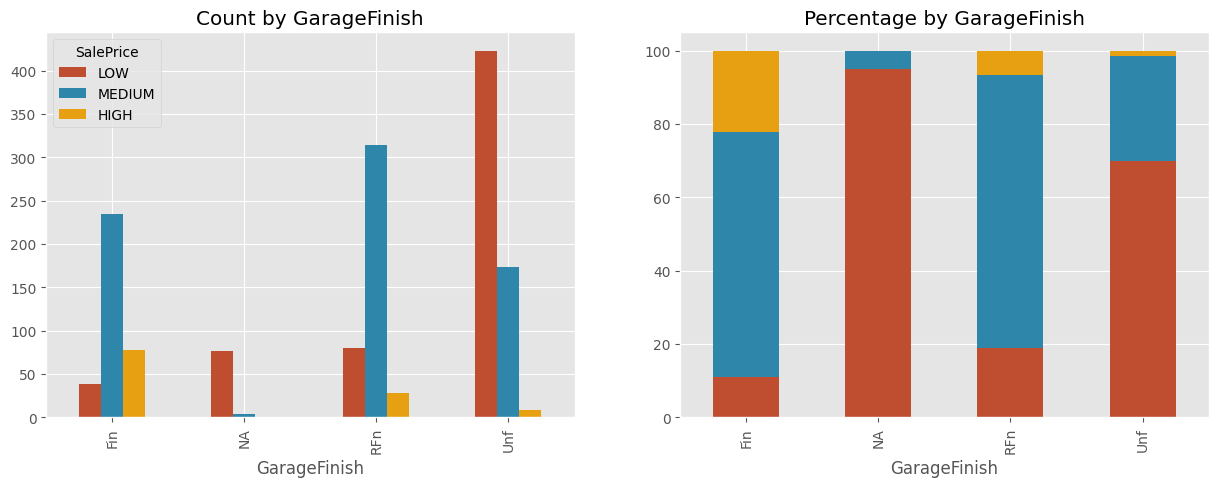

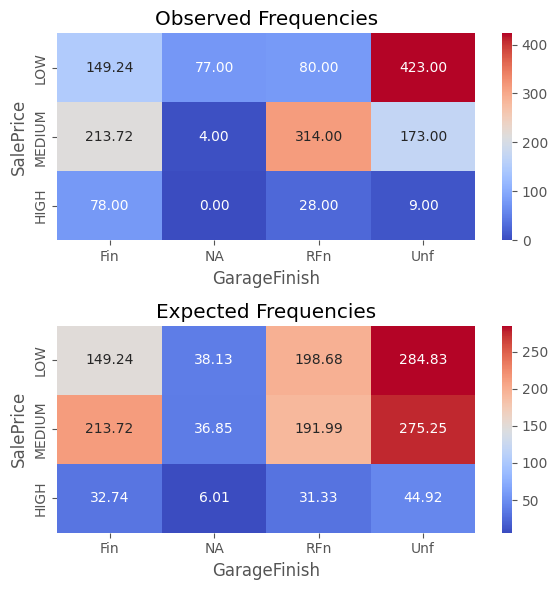

Chi-square Test - Outcome
P-Value: 2.2755608608462434e-123 [<0.05]


/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3050799574413959

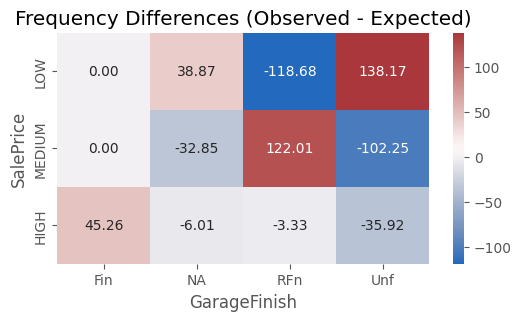

In [287]:
df_copy = df.copy(deep=True)
df_copy['GarageFinish'] = df['GarageFinish']
print(df_copy['GarageFinish'].unique())
df_copy['GarageFinish'] = df_copy['GarageFinish'].astype('category')
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'GarageFinish')
stattest_quali(df_copy, 'GarageFinish')
IG(df_copy, TARGET_FEATURE, 'GarageFinish')

SalePrice           LOW     MEDIUM       HIGH
GarageFinish                                 
Fin           11.079545  66.761364  22.159091
NA            95.061728   4.938272   0.000000
RFn           18.957346  74.407583   6.635071
Unf           69.917355  28.595041   1.487603

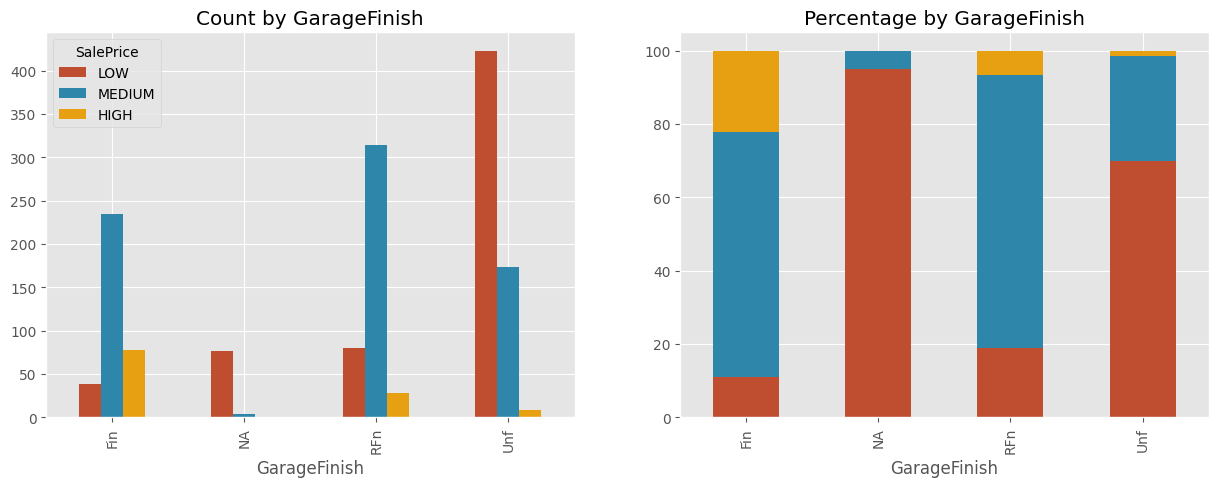

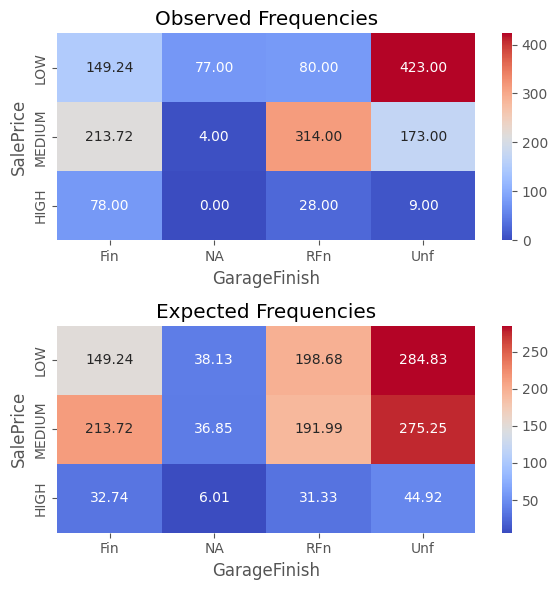

Chi-square Test - Outcome
P-Value: 2.2755608608462434e-123 [<0.05]
Understanding GarageFinish:
	Missing values: 0
	Independence Test: 2.28e-123[<0.05]
	Information Gain: 0.31
	When the GarageFinish is:
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• RFn, then the sale price is 70% likely to be MEDIUM (28.90% of the times)
		• Fin, then the sale price is 65% likely to be MEDIUM (24.11% of the times)
		• Unf, then the sale price is 65% likely to be LOW (41.44% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


TypeError: cannot unpack non-iterable NoneType object

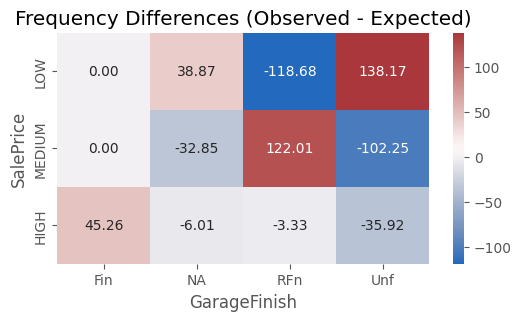

In [288]:
repo, ig, p_value = understand(df_copy, 'GarageFinish', 'category', showplots=True, na = 0)
print(repo)

##### GarageCars

In [ ]:
# understand(df_copy, 'GarageCars', 'category', showplots=True)
categoric_ordinal_plot(df_copy, 'GarageCars')

##### GarageArea

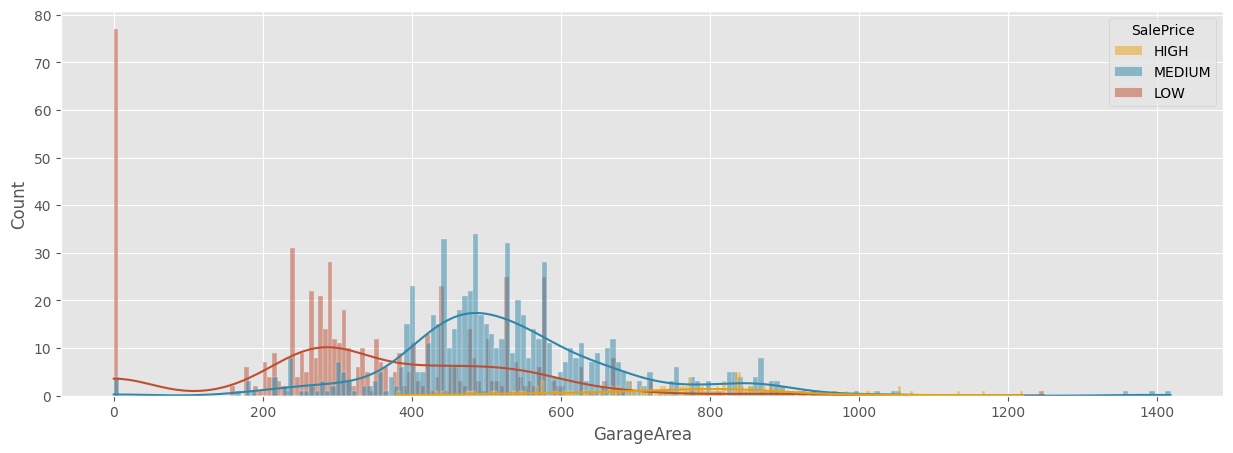

ANOVA Test - Outcome
P-Value: 0.0 [<0.05]


(0.0, '[<0.05]')

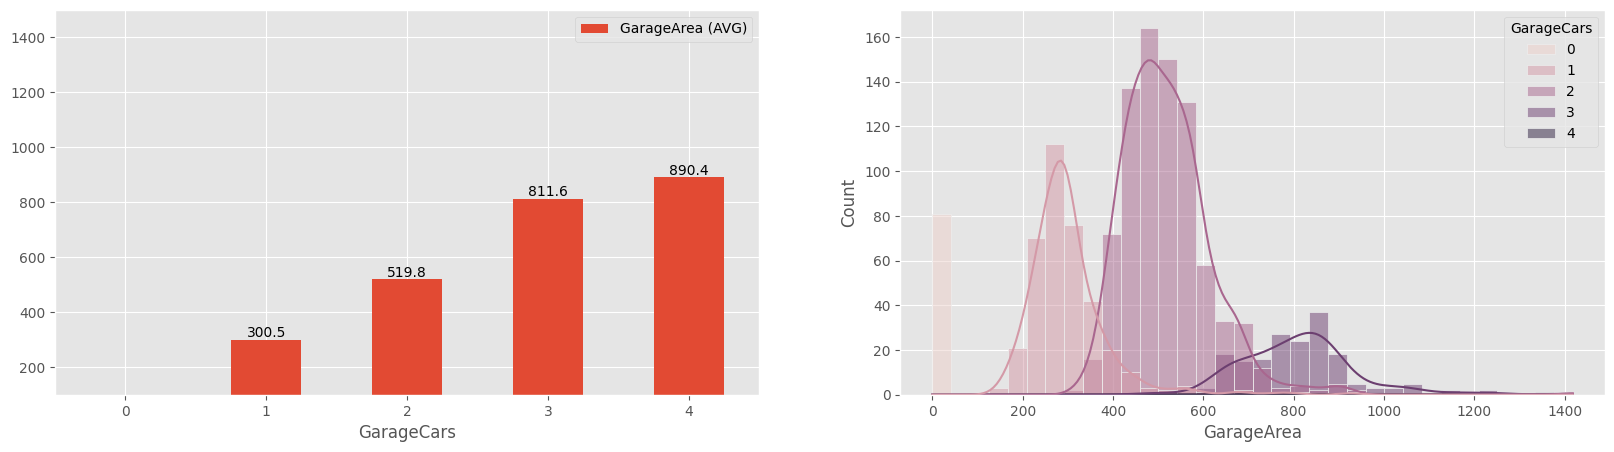

In [301]:
histplot(df_copy,TARGET_FEATURE ,'GarageArea', bins=200)
# correlation(df_copy,'GarageCars','GarageArea')
stattest_quanti(df_copy, 'GarageArea', 'GarageCars', low_limit= 100, upper_limit= 1500)

##### GarageQual

In [ ]:
understand(df_copy,'GarageQual',dtype='category',showplots=True,na=0)

##### GarageCond

In [ ]:
understand(df_copy,'GarageCond')

##### PavedDrive

SalePrice         LOW     MEDIUM     HIGH
PavedDrive                               
N           82.222222  17.777778  0.00000
P           66.666667  33.333333  0.00000
Y           39.179104  52.238806  8.58209

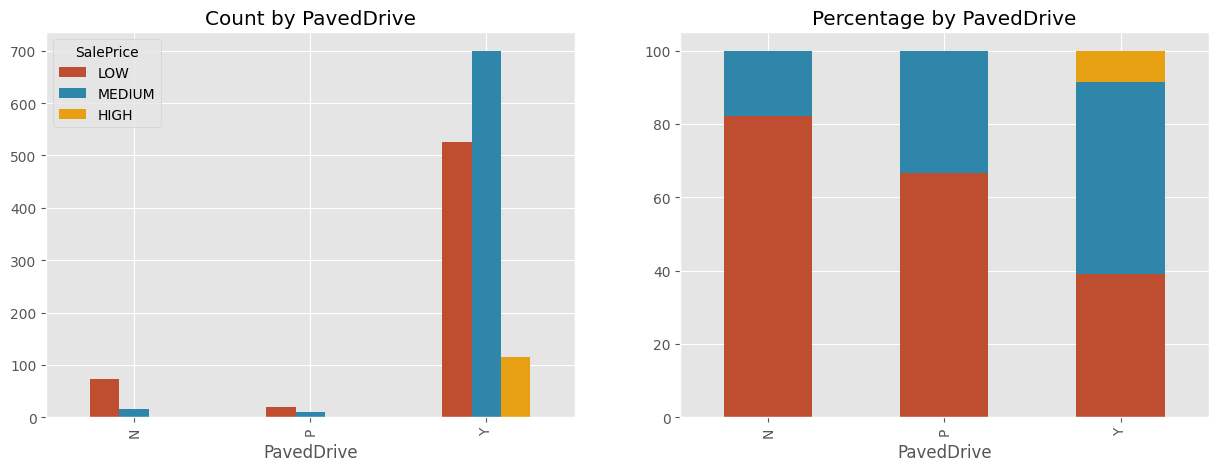

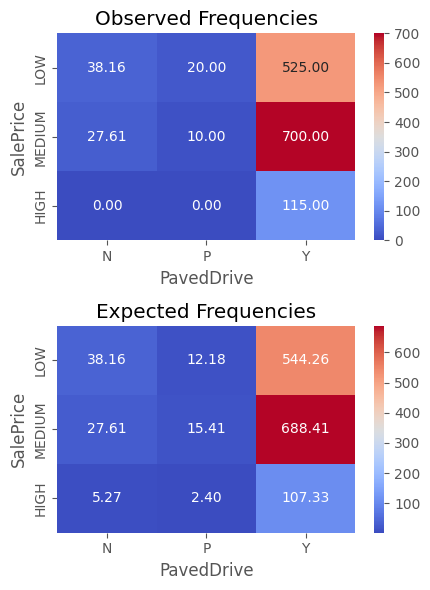

Chi-square Test - Outcome
P-Value: 4.777722451310024e-15 [<0.05]
Understanding PavedDrive:
	Missing values: 0
	Independence Test: 4.78e-15[<0.05]
	Information Gain: 0.04
	When the PavedDrive is:
		• N, then the sale price is 80% likely to be LOW (6.16% of the times)
		• P, then the sale price is 65% likely to be LOW (2.05% of the times)
		• Y, then the sale price is 50% likely to be MEDIUM (91.78% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


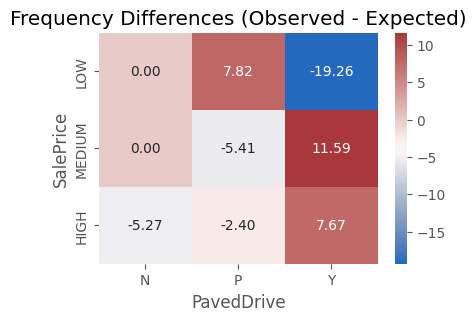

In [ ]:
understand(df_copy,'PavedDrive')

##### WoodDeckSF

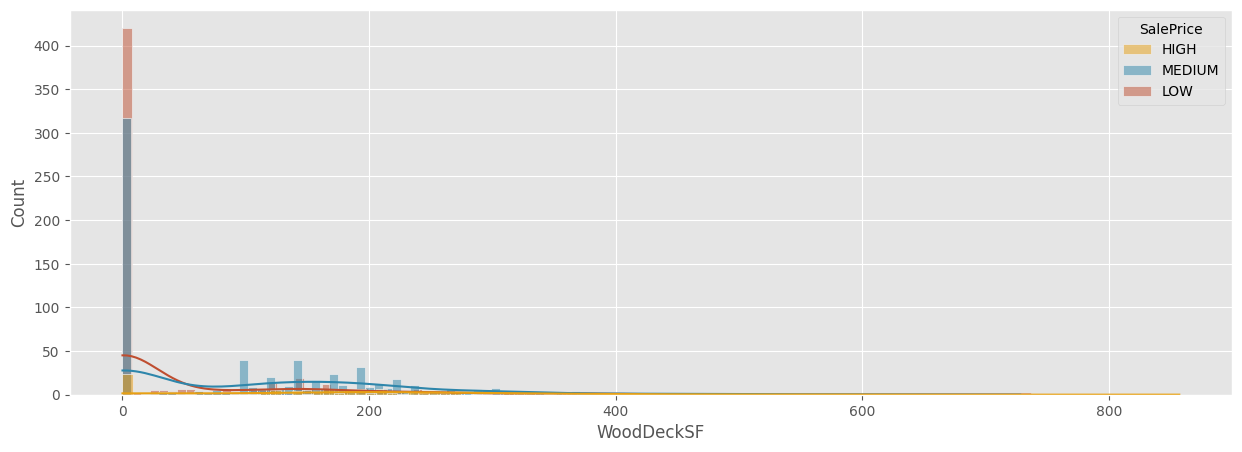

Understanding WoodDeckSF:
	Missing values: 0
	Independence Test: 1.12e-34[<0.05]
	Correlation Index: 0.32
	Correlation p_value: 3.97e-37



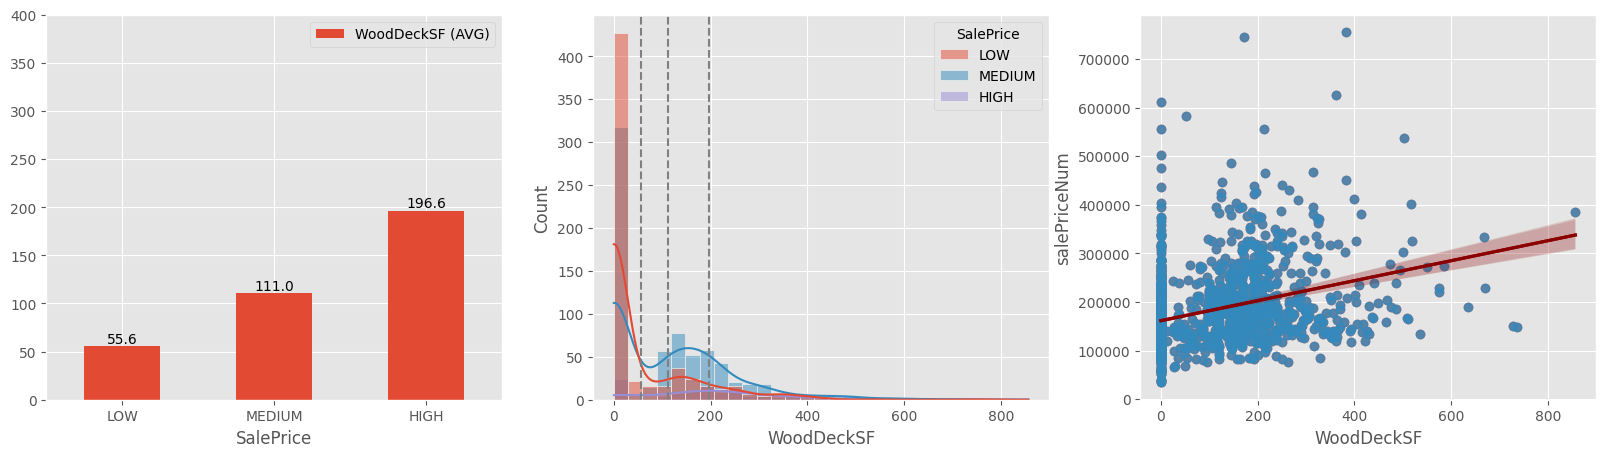

In [ ]:
understand(df_copy, 'WoodDeckSF', dtype='int', bins=100, upper_limit=400)

##### OpenPorchSF

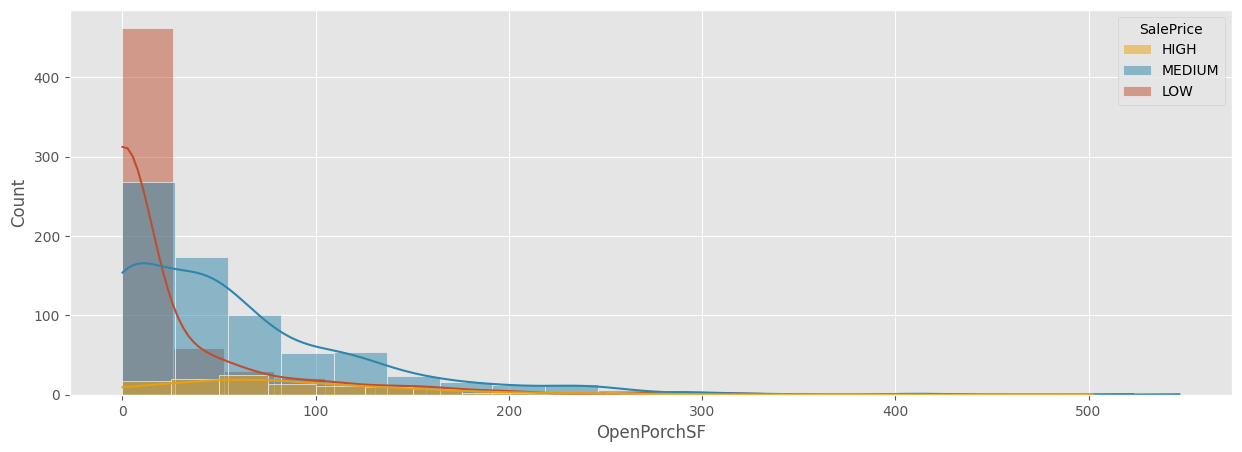

Understanding OpenPorchSF:
	Missing values: 0
	Independence Test: 3.15e-33[<0.05]
	Correlation Index: 0.32
	Correlation p_value: 3.49e-35



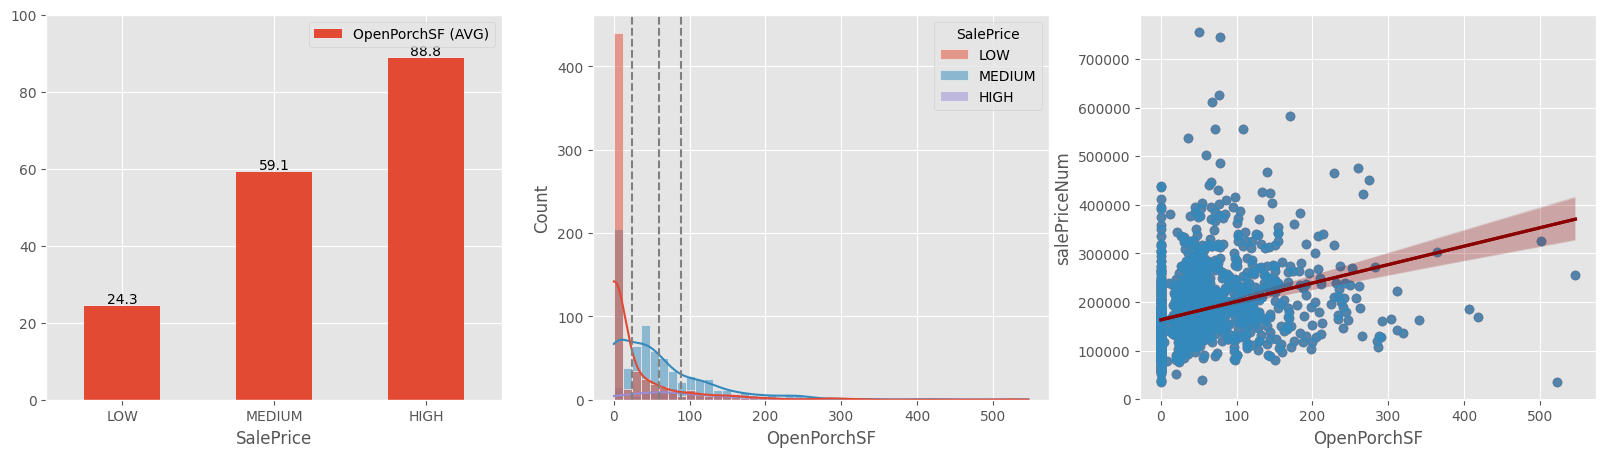

In [ ]:
understand(df_copy, 'OpenPorchSF', dtype='int', bins=20)

##### EnclosedPorch

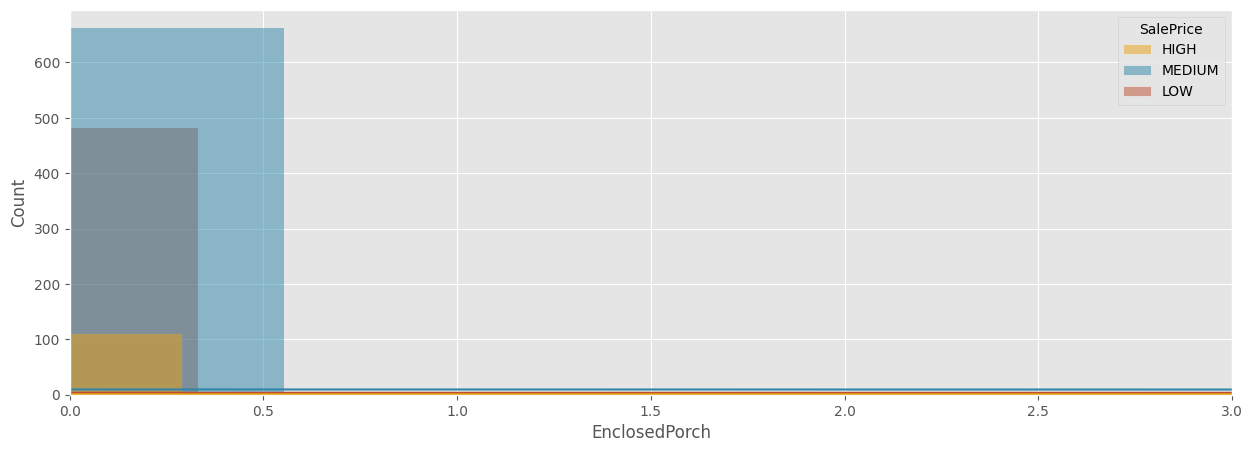

Understanding EnclosedPorch:
	Missing values: 0
	Independence Test: 5.12e-07[<0.05]
	Correlation Index: -0.13
	Correlation p_value: 8.26e-07



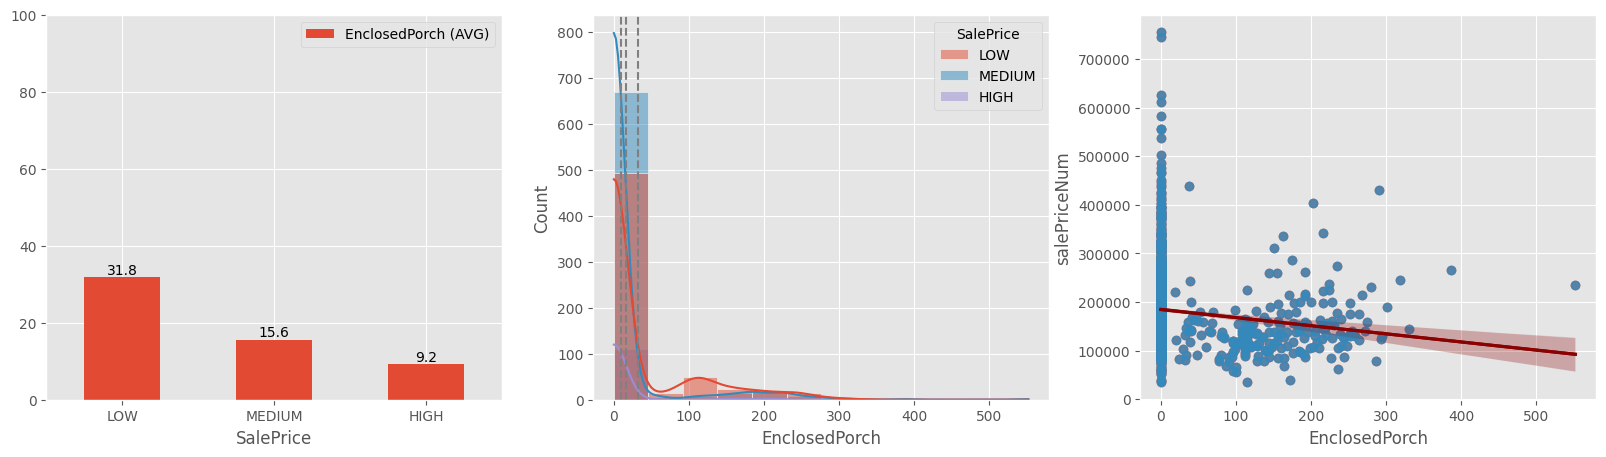

In [ ]:
understand(df_copy, 'EnclosedPorch', dtype='int', bins=1000, xlim=(0,3))

##### 3SsnPorch

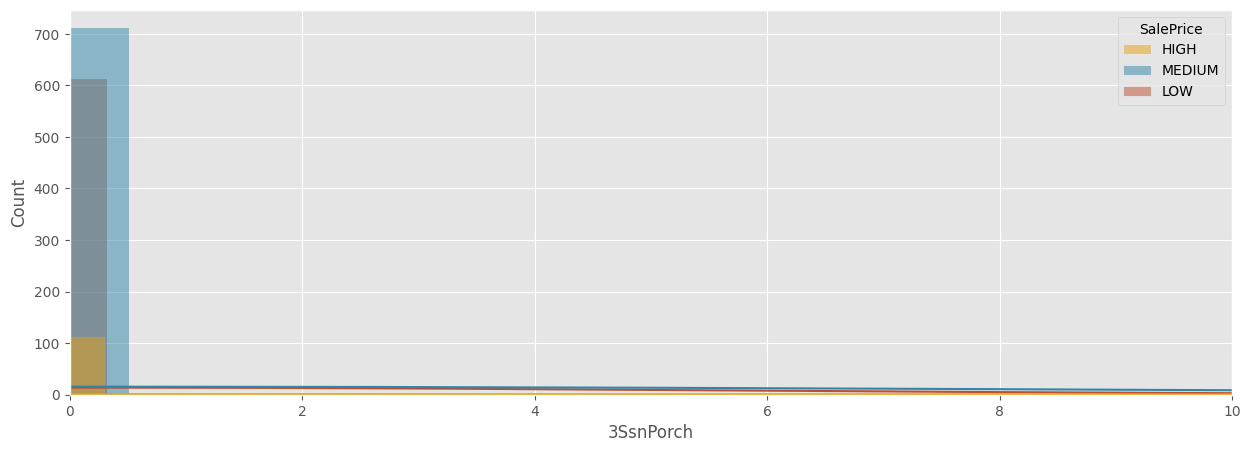

Understanding 3SsnPorch:
	Missing values: 0
	Independence Test: 2.40e-01
	Correlation Index: 0.04
	Correlation p_value: 8.86e-02



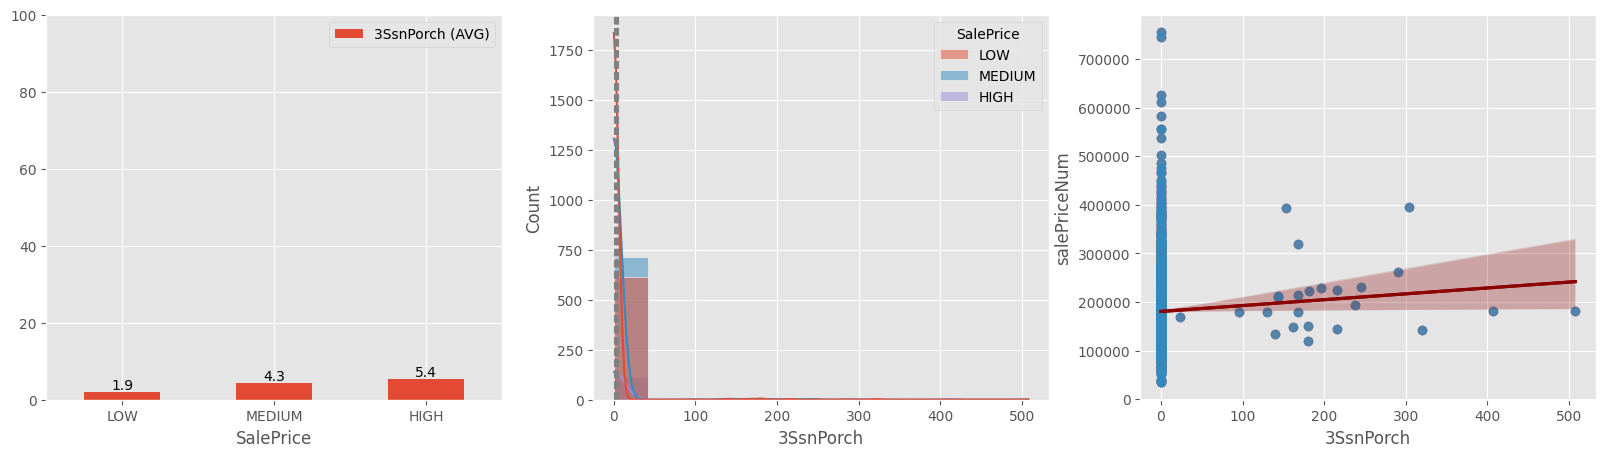

In [ ]:
understand(df_copy, '3SsnPorch', dtype='int', bins=1000, xlim=(0,10))

##### ScreenPorch

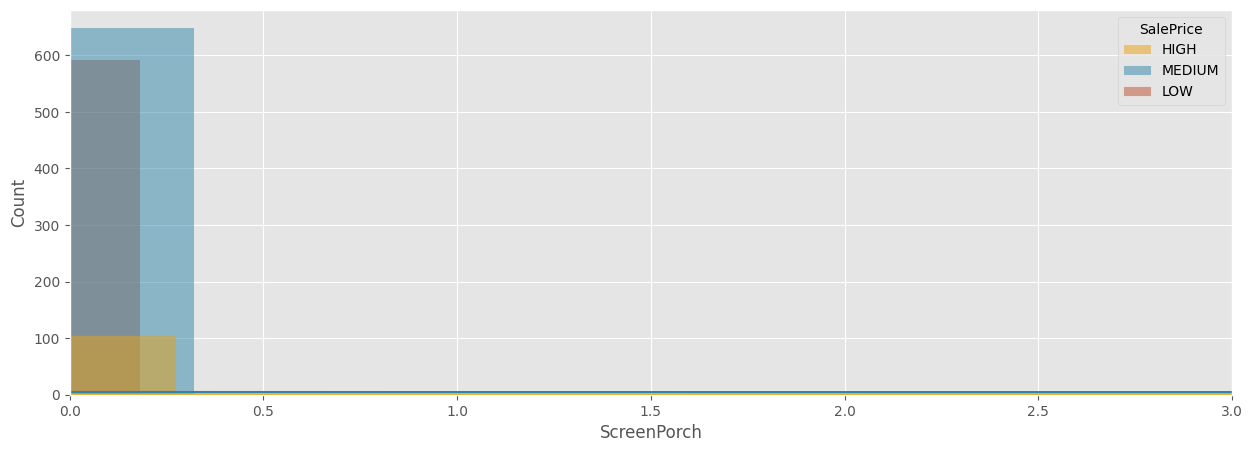

Understanding ScreenPorch:
	Missing values: 0
	Independence Test: 1.59e-06[<0.05]
	Correlation Index: 0.11
	Correlation p_value: 1.97e-05



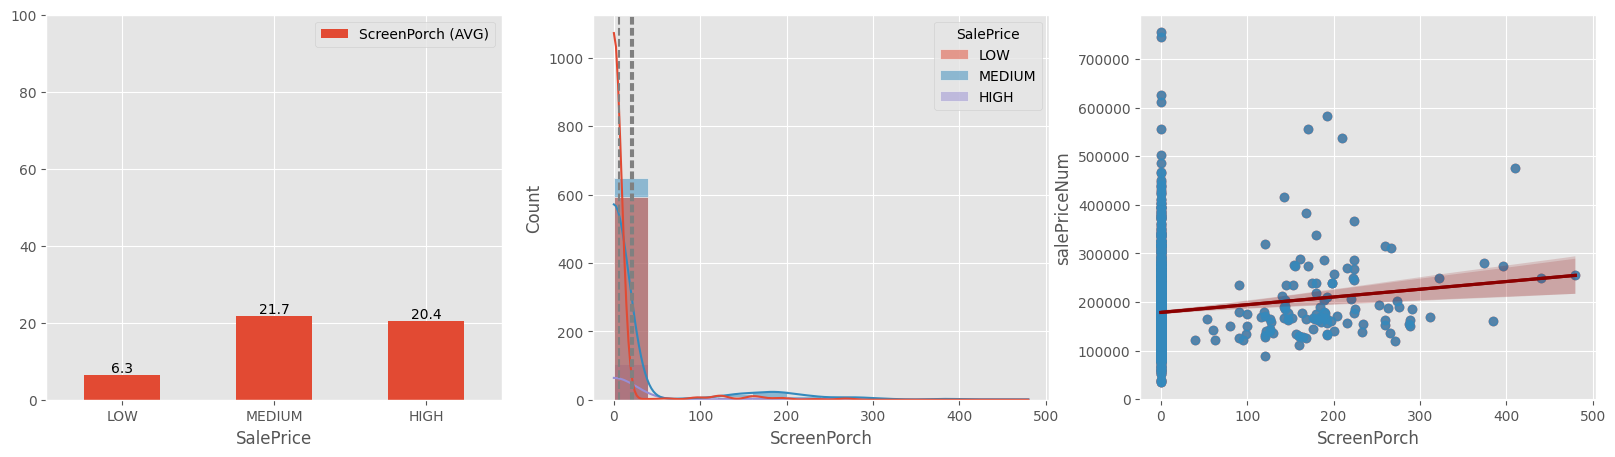

In [ ]:
understand(df_copy, 'ScreenPorch', dtype='int', bins=1500, xlim=(0,3))


##### PoolArea

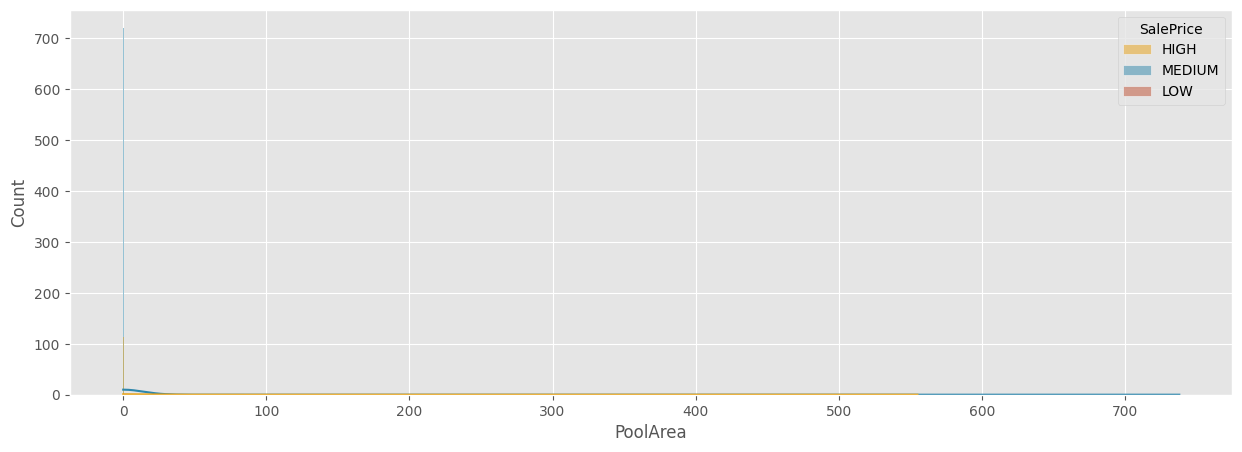

Understanding PoolArea:
	Missing values: 0
	Independence Test: 7.93e-02
	Correlation Index: 0.09
	Correlation p_value: 4.07e-04



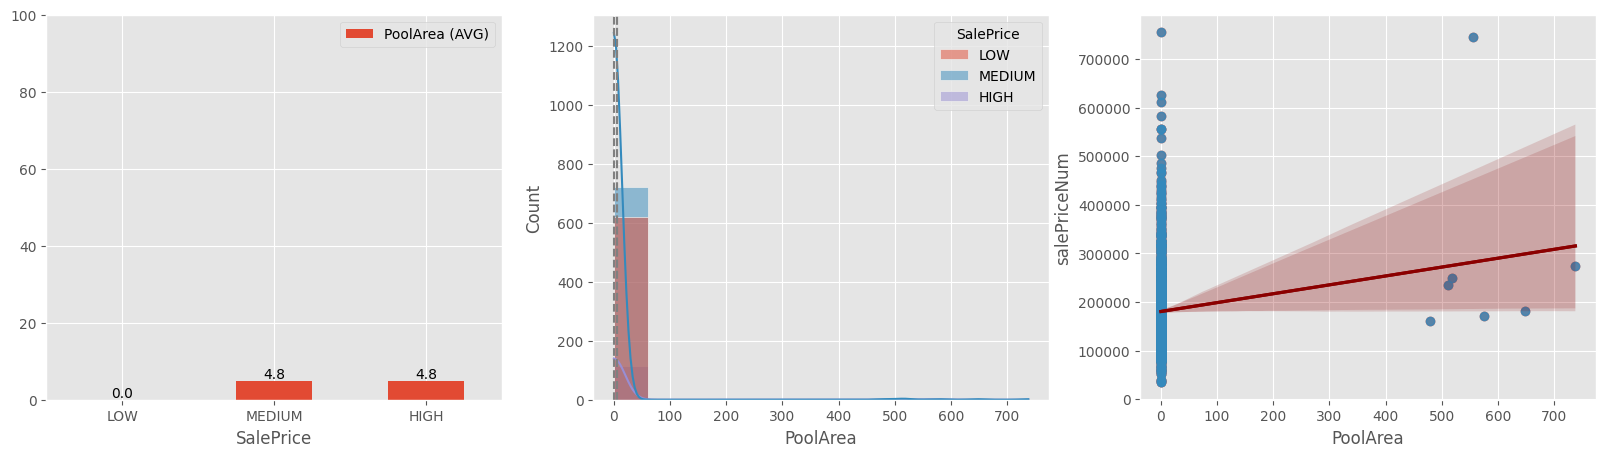

In [ ]:
understand(df_copy, 'PoolArea', dtype='int', bins=1500)

##### PoolQC

SalePrice        LOW     MEDIUM       HIGH
PoolQC                                    
Ex          0.000000   50.00000  50.000000
Fa          0.000000  100.00000   0.000000
Gd          0.000000  100.00000   0.000000
NA         42.601514   49.55265   7.845836

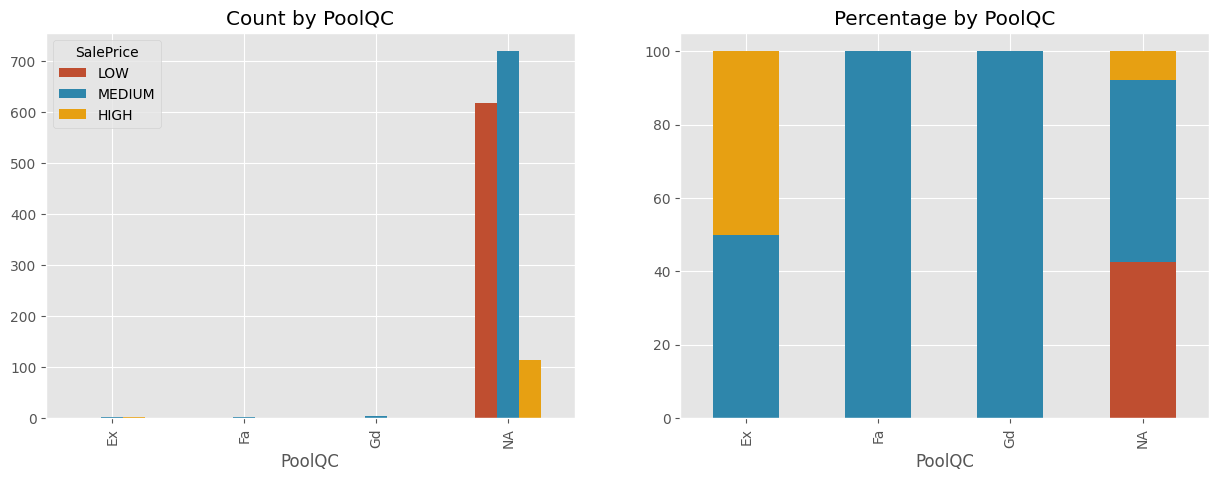

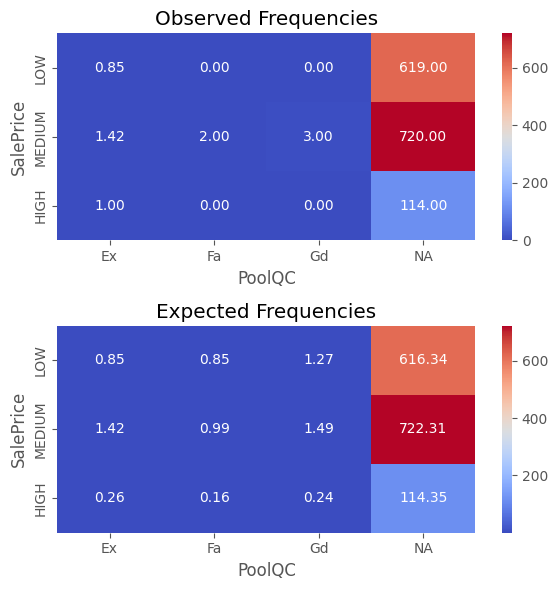

Chi-square Test - Outcome
P-Value: 0.10755220456771697 
Understanding PoolQC:
	Missing values: 0
	Independence Test: 1.08e-01
	Information Gain: 0.01
	When the PoolQC is:
		• Fa+Gd, then the sale price is MEDIUM (0.34% of the times)
		• Ex, then the sale price is 50% likely to be MEDIUM (0.14% of the times)
		• NA, then the sale price is 45% likely to be MEDIUM (99.52% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


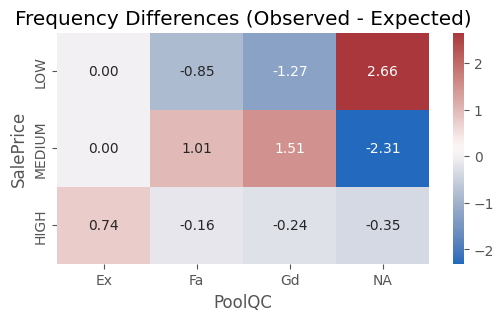

In [ ]:
understand(dataf=df_copy, feature_name= 'PoolQC', na = 0)

##### Fence

SalePrice        LOW     MEDIUM      HIGH
Fence                                    
GdPrv      28.813559  69.491525  1.694915
GdWo       72.222222  25.925926  1.851852
MnPrv      66.242038  31.847134  1.910828
MnWw       90.909091   9.090909  0.000000
NA         38.083121  52.586938  9.329941

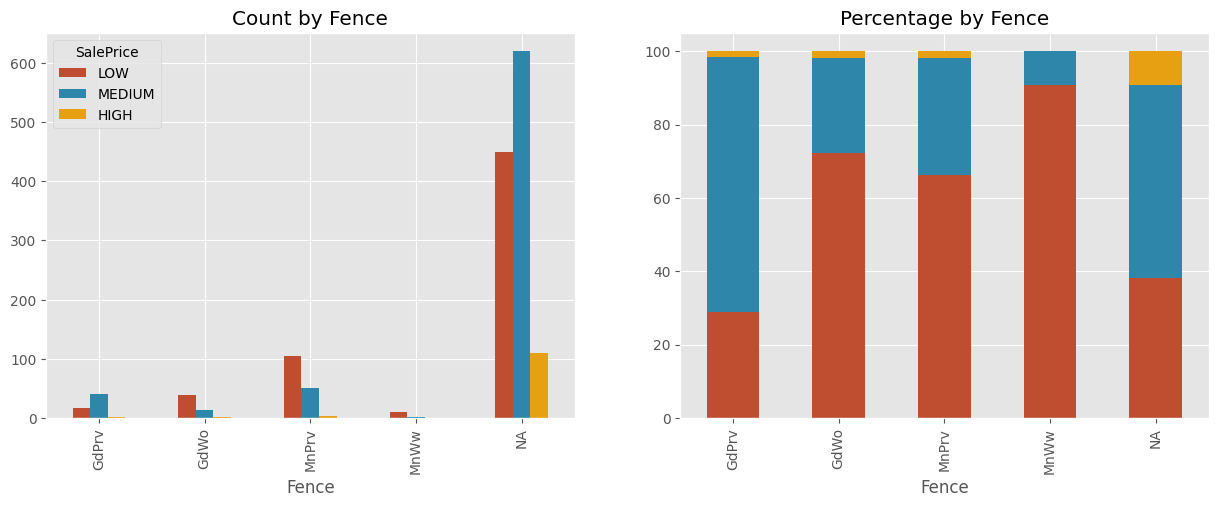

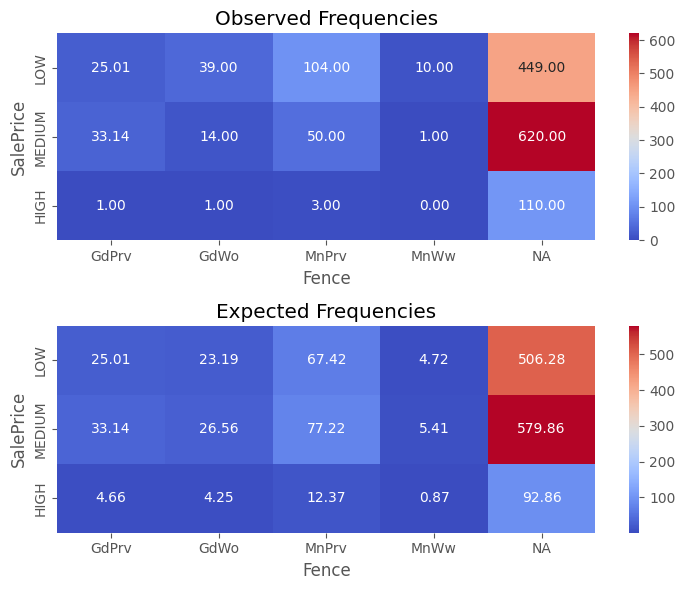

Chi-square Test - Outcome
P-Value: 6.825903732579082e-16 [<0.05]
Understanding Fence:
	Missing values: 0
	Independence Test: 6.83e-16[<0.05]
	Information Gain: 0.05
	When the Fence is:
		• MnWw, then the sale price is 90% likely to be LOW (0.75% of the times)
		• GdWo, then the sale price is 70% likely to be LOW (3.70% of the times)
		• GdPrv, then the sale price is 65% likely to be MEDIUM (4.04% of the times)
		• MnPrv, then the sale price is 65% likely to be LOW (10.75% of the times)
		• NA, then the sale price is 50% likely to be MEDIUM (80.75% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


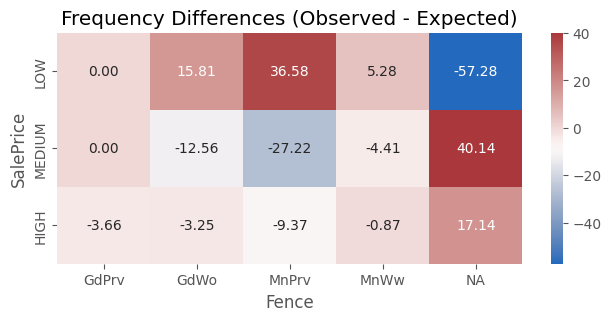

In [ ]:
understand(dataf=df_copy, feature_name= 'Fence', na = 0)


##### MiscFeature

SalePrice           LOW      MEDIUM      HIGH
MiscFeature                                  
Gar2           0.000000  100.000000  0.000000
NA            41.891892   49.928876  8.179232
Othr         100.000000    0.000000  0.000000
Shed          57.142857   42.857143  0.000000
TenC           0.000000  100.000000  0.000000

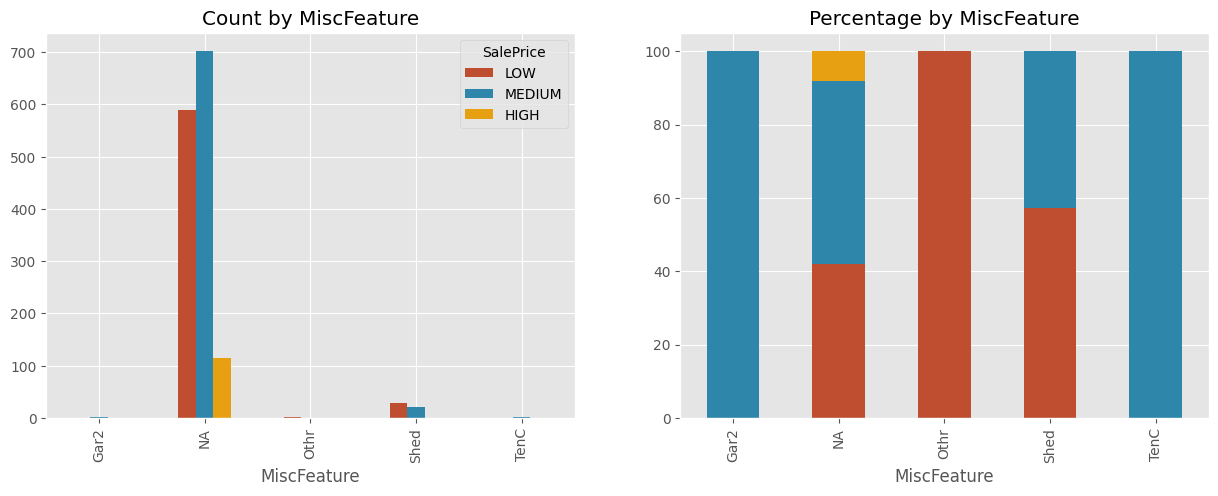

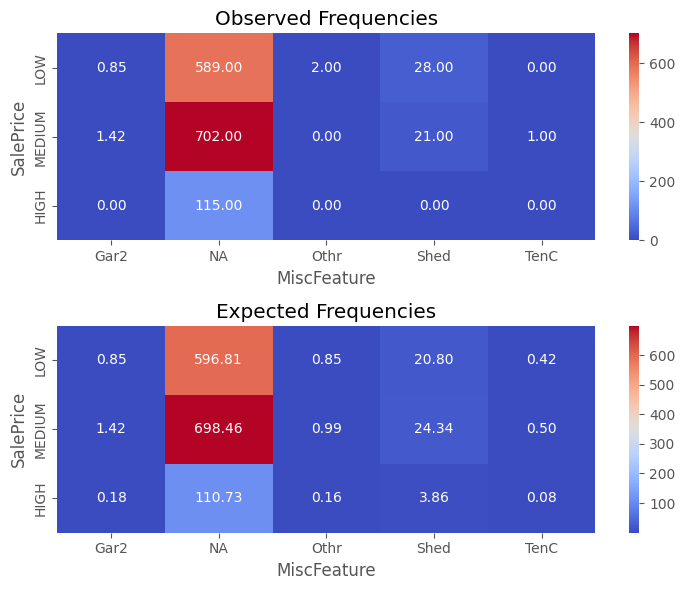

Chi-square Test - Outcome
P-Value: 0.11720562475052677 
Understanding MiscFeature:
	Missing values: 0
	Independence Test: 1.17e-01
	Information Gain: 0.01
	When the MiscFeature is:
		• Othr, then the sale price is LOW (0.14% of the times)
		• Gar2+TenC, then the sale price is MEDIUM (0.21% of the times)
		• Shed, then the sale price is 55% likely to be LOW (3.36% of the times)
		• NA, then the sale price is 45% likely to be MEDIUM (96.30% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


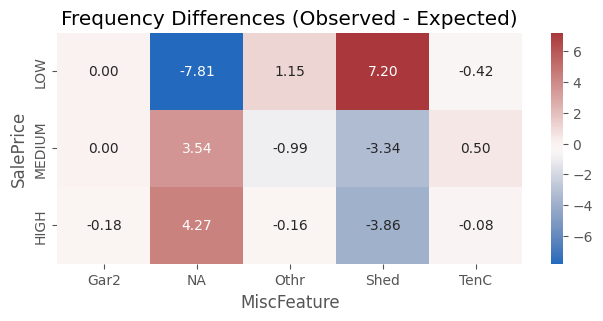

In [ ]:
understand(dataf=df_copy, feature_name= 'MiscFeature', na = 0)


##### MiscVal

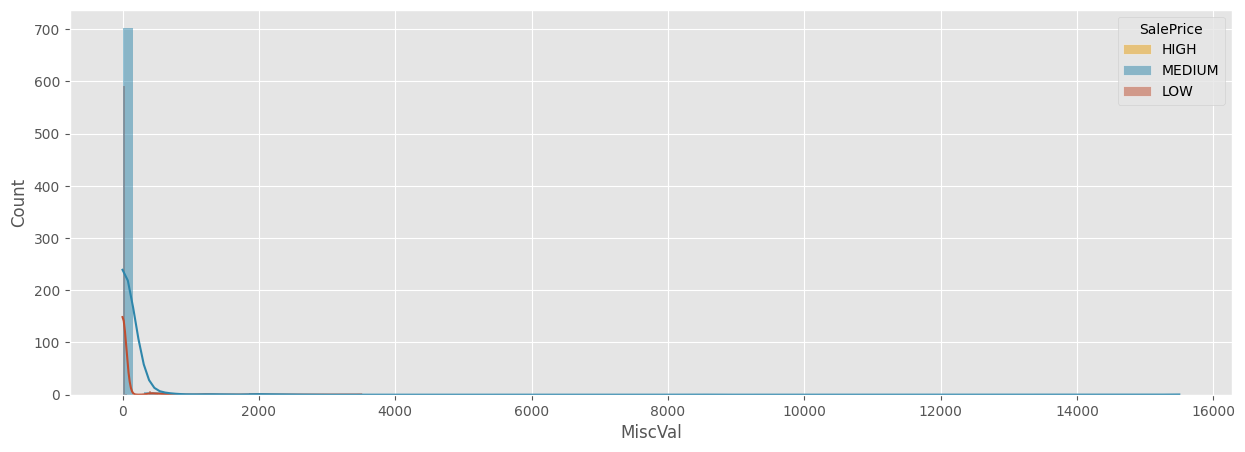

Understanding MiscVal:
	Missing values: 0
	Independence Test: 3.64e-01
	Correlation Index: -0.02
	Correlation p_value: 4.18e-01



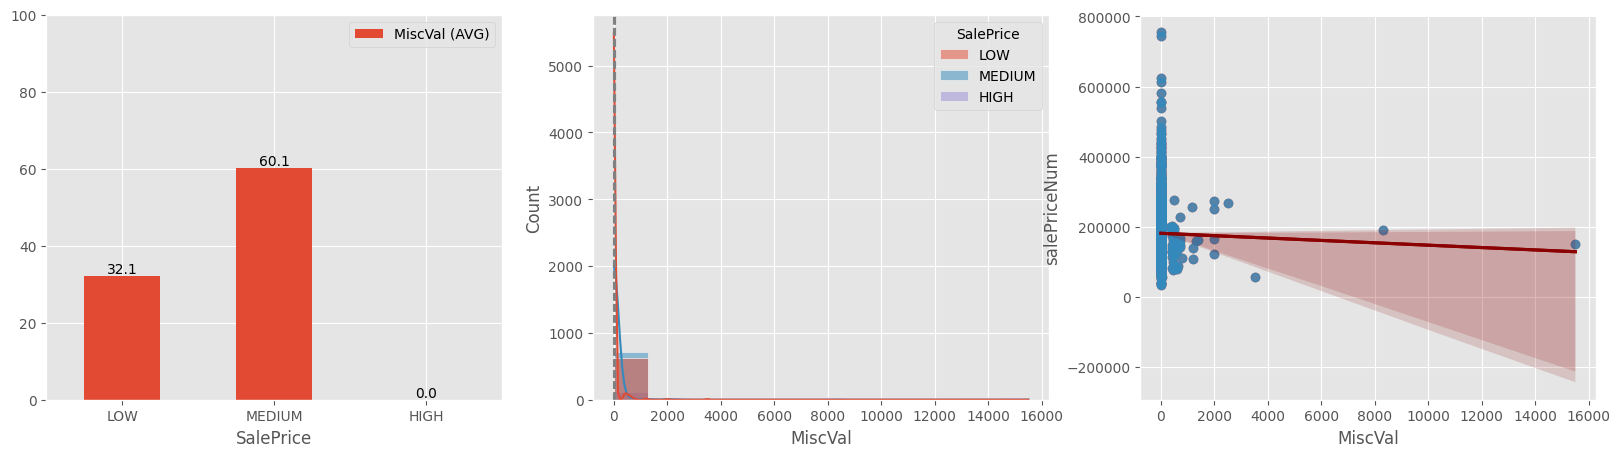

In [ ]:
understand(df_copy, 'MiscVal', dtype='int', bins=100)

##### MoSold

SalePrice        LOW     MEDIUM       HIGH
MoSold                                    
MoSold_1   50.000000  41.379310   8.620690
MoSold_10  43.820225  48.314607   7.865169
MoSold_11  39.240506  48.101266  12.658228
MoSold_12  37.288136  55.932203   6.779661
MoSold_2   40.384615  55.769231   3.846154
MoSold_3   38.679245  51.886792   9.433962
MoSold_4   53.191489  40.425532   6.382979
MoSold_5   48.529412  45.098039   6.372549
MoSold_6   38.339921  56.126482   5.533597
MoSold_7   39.316239  51.709402   8.974359
MoSold_8   40.983607  50.000000   9.016393
MoSold_9   36.507937  49.206349  14.285714

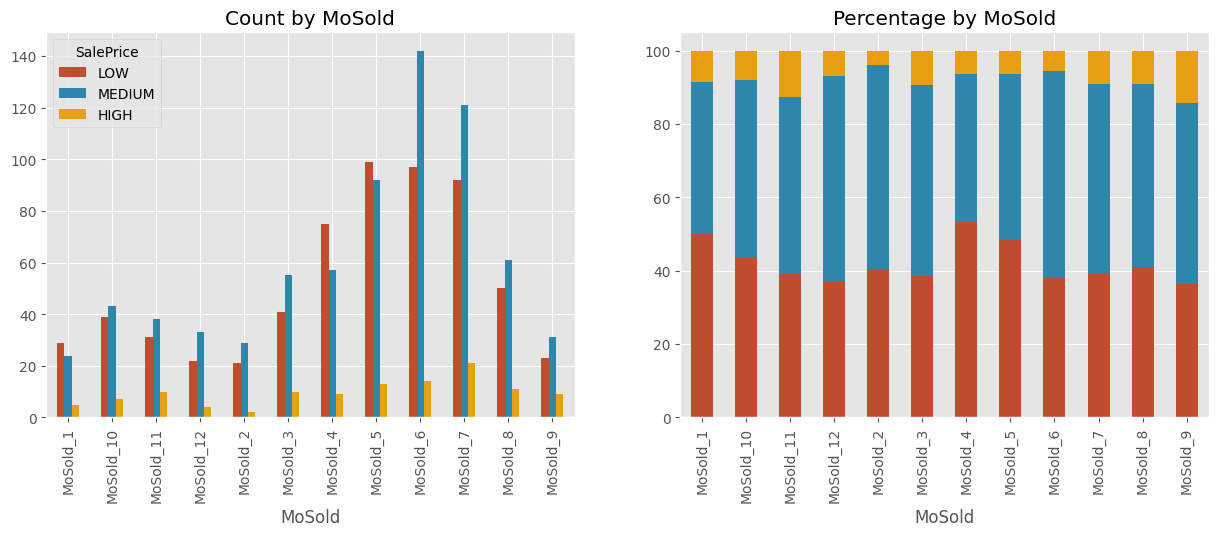

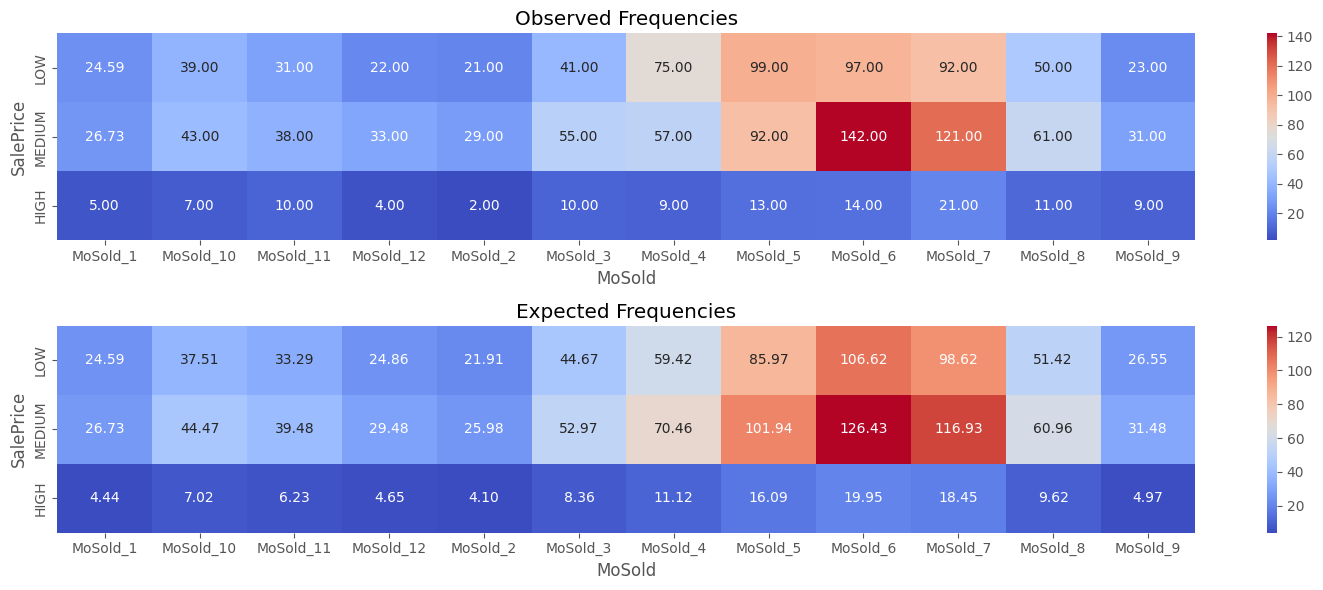

Chi-square Test - Outcome
P-Value: 0.19672812545573456 
Understanding MoSold:
	Missing values: 0
	Independence Test: 1.97e-01
	Information Gain: 0.01
	When the MoSold is:
		• MoSold_12+MoSold_2+MoSold_6, then the sale price is 55% likely to be MEDIUM (24.93% of the times)
		• MoSold_1+MoSold_4, then the sale price is 50% likely to be LOW (13.63% of the times)
		• MoSold_3+MoSold_7+MoSold_8, then the sale price is 50% likely to be MEDIUM (31.64% of the times)
		• MoSold_5, then the sale price is 45% likely to be LOW (13.97% of the times)
		• MoSold_10+MoSold_11+MoSold_9, then the sale price is 45% likely to be MEDIUM (15.82% of the times)




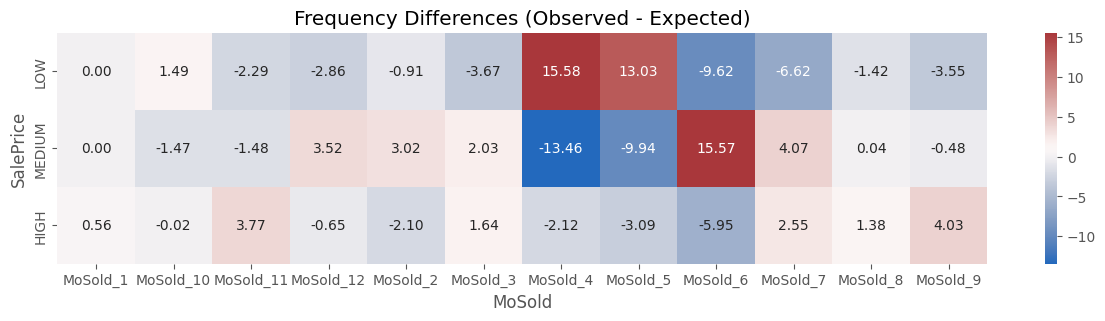

In [293]:
understand(dataf=df_copy, feature_name='MoSold', dtype='object')

##### YrSold

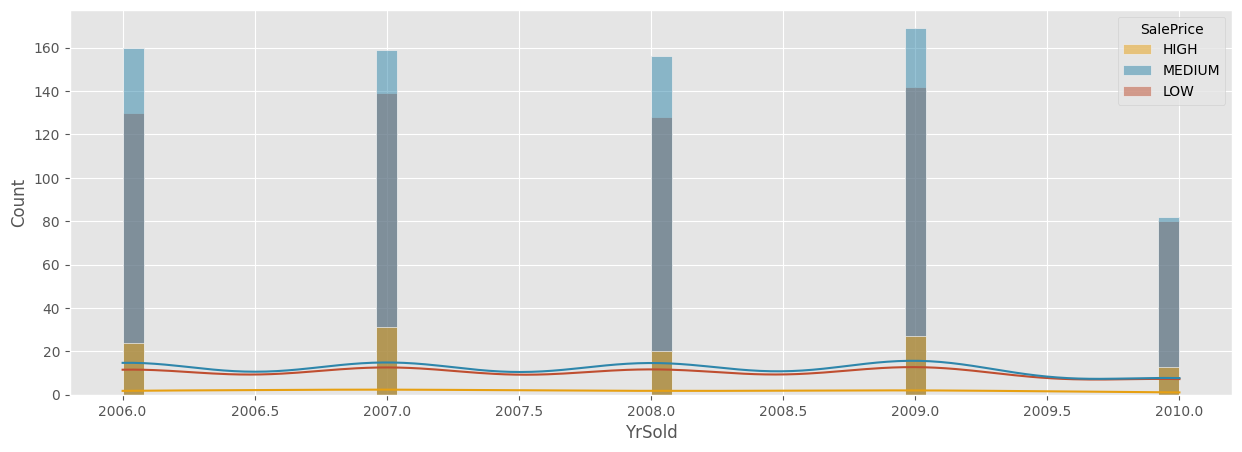

Understanding YrSold:
	Missing values: 0
	Independence Test: 7.80e-01
	Correlation Index: -0.03
	Correlation p_value: 2.69e-01



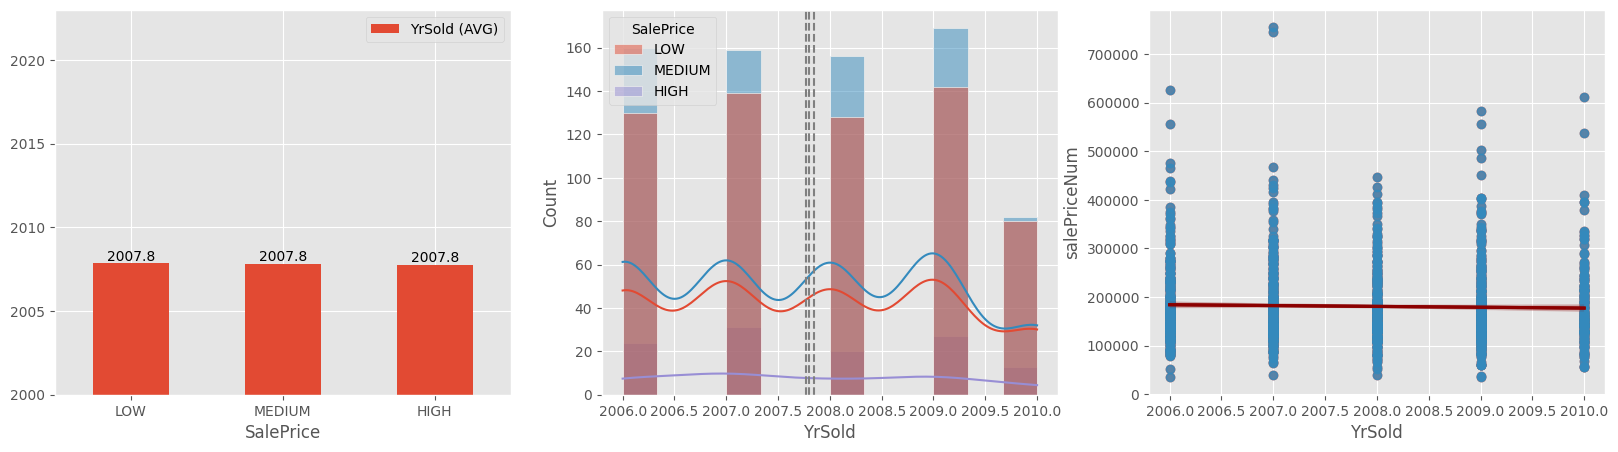

In [296]:
understand(df_copy, 'YrSold', dtype='int', upper_limit=2023, low_limit= 2000)

##### SaleType

SalePrice         LOW     MEDIUM       HIGH
SaleType                                   
COD         62.790698  37.209302   0.000000
CWD         25.000000  50.000000  25.000000
Con          0.000000  50.000000  50.000000
ConLD       66.666667  33.333333   0.000000
ConLI       60.000000  20.000000  20.000000
ConLw       60.000000  40.000000   0.000000
New          3.278689  62.295082  34.426230
Oth        100.000000   0.000000   0.000000
WD          45.146014  49.329124   5.524862

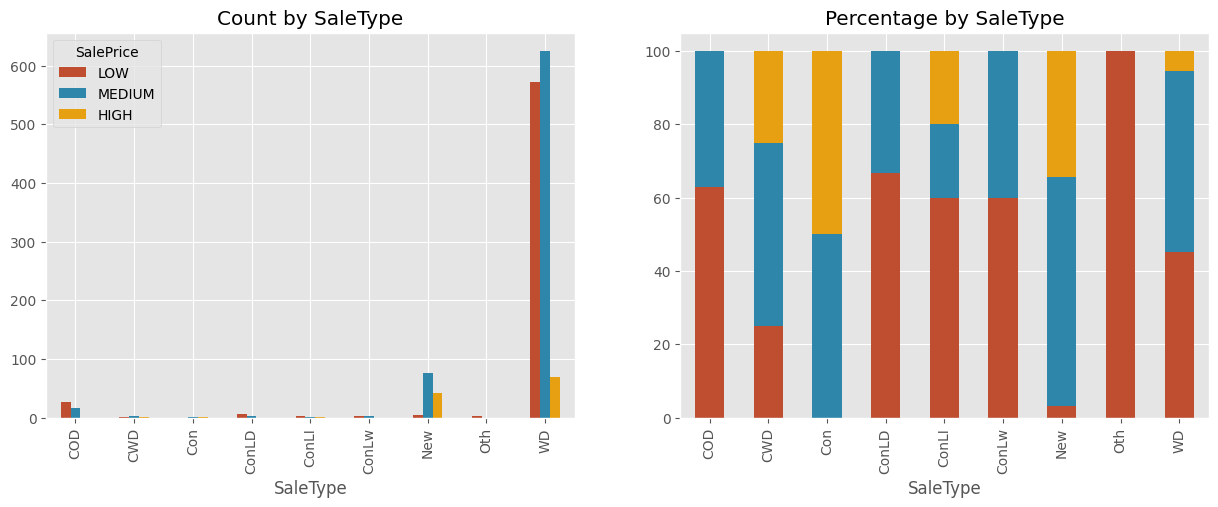

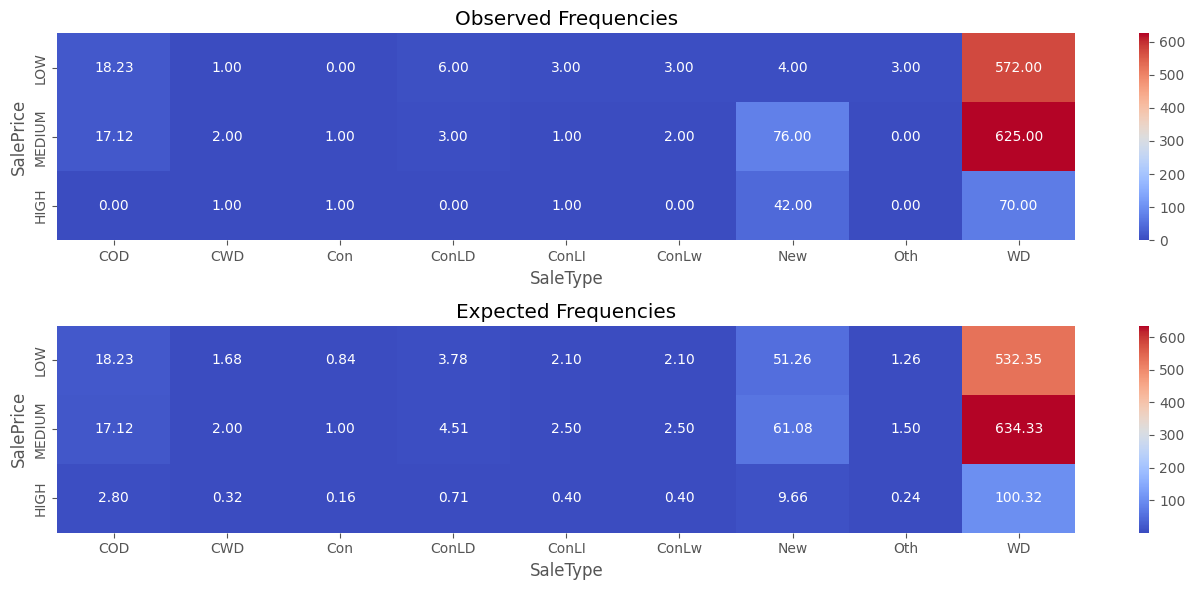

Chi-square Test - Outcome
P-Value: 1.331354726540166e-32 [<0.05]
Understanding SaleType:
	Missing values: 0
	Independence Test: 1.33e-32[<0.05]
	Information Gain: 0.09
	When the SaleType is:
		• Oth, then the sale price is LOW (0.21% of the times)
		• ConLD, then the sale price is 65% likely to be LOW (0.62% of the times)
		• COD+ConLI+ConLw, then the sale price is 60% likely to be LOW (3.63% of the times)
		• New, then the sale price is 60% likely to be MEDIUM (8.36% of the times)
		• CWD+Con, then the sale price is 50% likely to be MEDIUM (0.41% of the times)
		• WD, then the sale price is 45% likely to be LOW (86.78% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


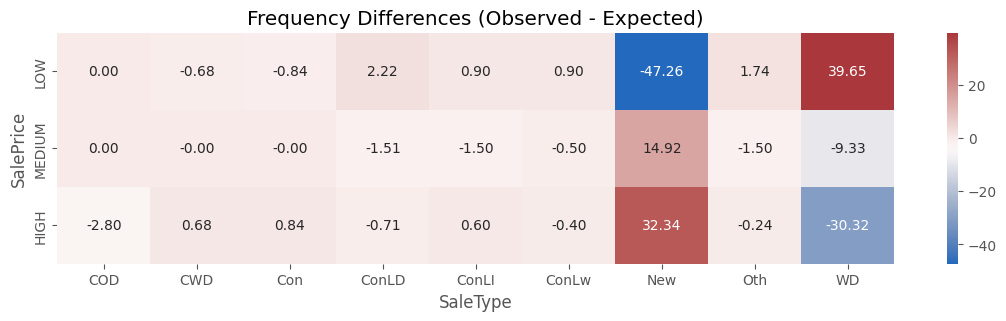

In [297]:
understand(dataf=df_copy, feature_name='SaleType')

##### SaleCondition

SalePrice             LOW     MEDIUM       HIGH
SaleCondition                                  
Abnorml         67.326733  29.702970   2.970297
AdjLand        100.000000   0.000000   0.000000
Alloca          50.000000  41.666667   8.333333
Family          60.000000  40.000000   0.000000
Normal          43.656093  50.584307   5.759599
Partial          4.800000  61.600000  33.600000

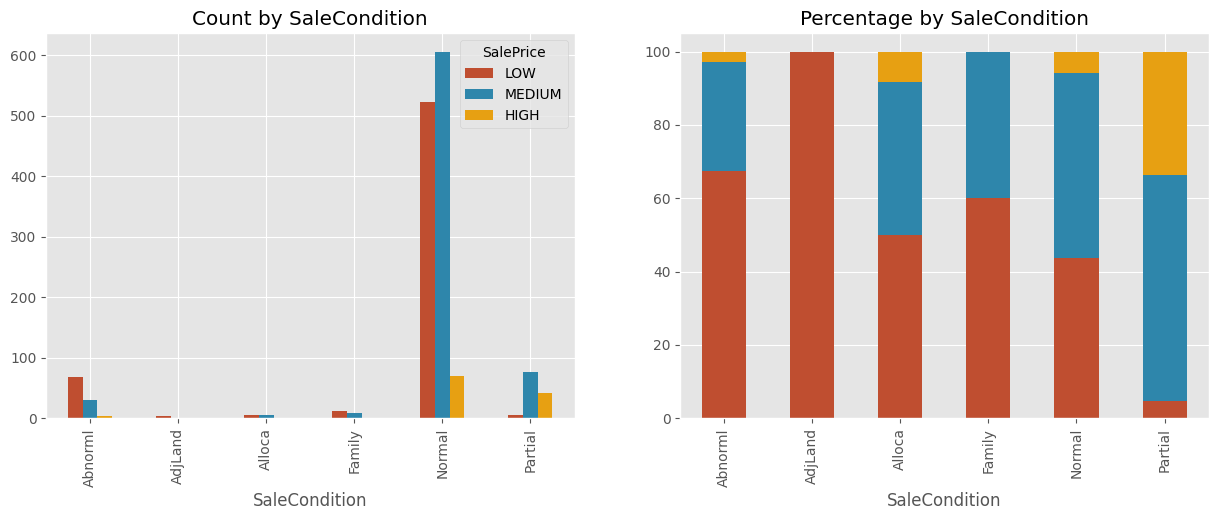

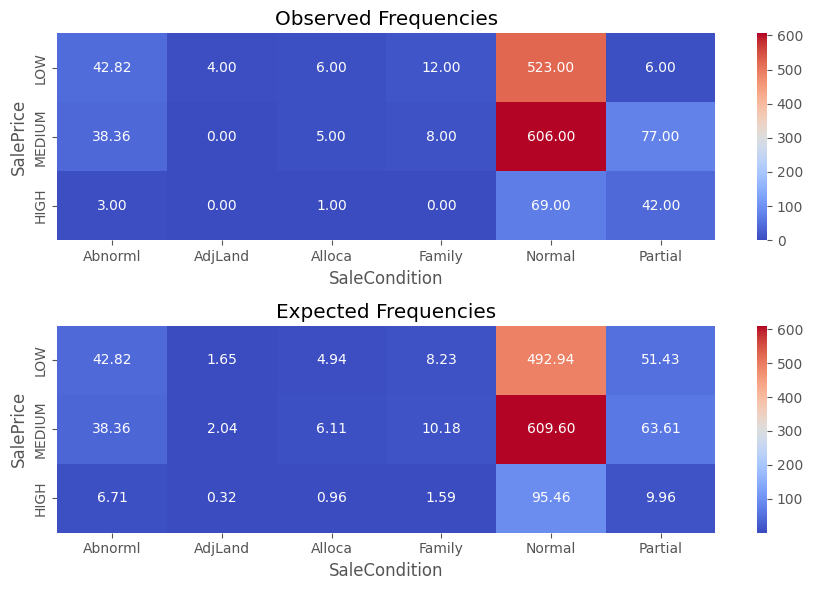

Chi-square Test - Outcome
P-Value: 4.916466420372617e-36 [<0.05]
Understanding SaleCondition:
	Missing values: 0
	Independence Test: 4.92e-36[<0.05]
	Information Gain: 0.09
	When the SaleCondition is:
		• AdjLand, then the sale price is LOW (0.27% of the times)
		• Abnorml, then the sale price is 65% likely to be LOW (6.92% of the times)
		• Family, then the sale price is 60% likely to be LOW (1.37% of the times)
		• Partial, then the sale price is 60% likely to be MEDIUM (8.56% of the times)
		• Alloca, then the sale price is 50% likely to be LOW (0.82% of the times)
		• Normal, then the sale price is 50% likely to be MEDIUM (82.05% of the times)




/home/instafiore/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


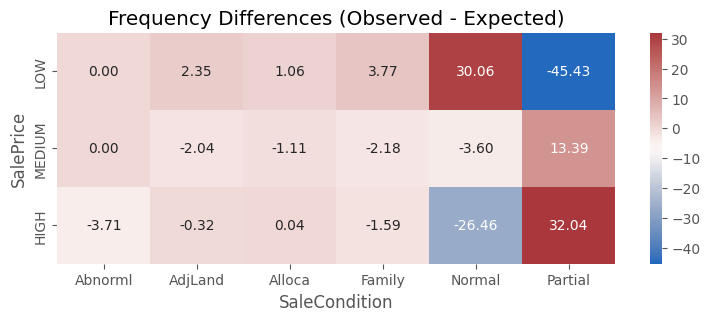

In [298]:
understand(dataf=df_copy, feature_name='SaleCondition')

#### Correlation

In [300]:
TODO 

NameError: name 'TODO' is not defined